In [37]:
# ============================================================================
# IMPORT CÁC THƯ VIỆN CẦN THIẾT CHO XAI-RL FRAMEWORK
# ============================================================================

# 1. System & Path
import sys
import os
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# 2. Data Processing
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 3. Deep Learning - PyTorch
import torch
from torch import nn
import torch.nn.functional as F

# 4. Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style cho plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 5. XAI Libraries - CHỈ DÙNG SHAP
try:
    import shap
    print("✓ SHAP available")
except ImportError:
    print("⚠ SHAP not installed - will install when needed")

# 6. Project-specific Imports
from agents.d_sarsa.d_sarsa import Qsa
from environments.stock_trading_env.mdp import StockTradingMDP
from data.data_provider.library_extracted.vnstock.VNStockDataProvider import VNStockDataProvider
from data.data_processor.feature_engineer import engineer_stat as es

# 7. Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("="*80)
print("✓ Tất cả thư viện đã được import thành công!")
print("="*80)
print("\n🎯 XAI-RL Framework - 3 Phương pháp độc lập:")
print("  [1] RDX  - Reward Decomposition (weights từ domain knowledge)")
print("  [2] MSX  - Multi-Step Explanation (trajectory analysis)")
print("  [3] SHAP - Feature Attribution (Shapley values)")
print("\n📊 Deep RL Agent:")
print("  • Qsa:              Q-network (input=7, output=11)")
print("  • StockTradingMDP:  Environment cho stock trading")
print("  • VNStockData:      Data provider cho VN market")
print("\nReady to analyze SARSA agent! 🚀")
print("="*80)

✓ SHAP available
✓ Tất cả thư viện đã được import thành công!

🎯 XAI-RL Framework - 3 Phương pháp độc lập:
  [1] RDX  - Reward Decomposition (weights từ domain knowledge)
  [2] MSX  - Multi-Step Explanation (trajectory analysis)
  [3] SHAP - Feature Attribution (Shapley values)

📊 Deep RL Agent:
  • Qsa:              Q-network (input=7, output=11)
  • StockTradingMDP:  Environment cho stock trading
  • VNStockData:      Data provider cho VN market

Ready to analyze SARSA agent! 🚀


In [38]:
# Fix NumPy version conflict cho SHAP
# SHAP requires NumPy <= 2.1, nhưng bạn đang dùng NumPy 2.2

!pip install "numpy<2.0" --upgrade
!pip install shap

print("\n" + "="*80)
print("⚠ QUAN TRỌNG: Sau khi cài đặt xong, bạn PHẢI RESTART KERNEL!")
print("   Cách restart: Kernel menu -> Restart Kernel")
print("   Sau đó chạy lại tất cả các cell từ đầu")
print("="*80)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



⚠ QUAN TRỌNG: Sau khi cài đặt xong, bạn PHẢI RESTART KERNEL!
   Cách restart: Kernel menu -> Restart Kernel
   Sau đó chạy lại tất cả các cell từ đầu



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
# 1.1. Load model SARSA
qsa = Qsa(input_size=7, num_classes=11)
model_path = 'd:\\NCKH\\SARSA_FinancialRL\\models\\sarsa_bad_acb.pth'

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    qsa.load_state_dict(state_dict)
    qsa.eval()
    print(f"✓ Model loaded: {model_path}")
else:
    print(f"✗ Model not found: {model_path}")

# 1.2. Load dữ liệu ACB
provider = VNStockDataProvider()
print("\nĐang lấy dữ liệu ACB từ vnstock...")
df_raw = provider.get_ohlcv_data('ACB', '2013-01-01', '2015-12-31')
print(f"✓ Đã lấy {len(df_raw)} dòng dữ liệu")

# 1.3. Xử lý dữ liệu và thêm technical indicators
df_processed = df_raw.copy()
df_processed.rename(columns={'date': 'time'}, inplace=True)
df_processed['time'] = pd.to_datetime(df_processed['time']).dt.strftime('%d/%m/%Y')
df_processed = es.add_technical_indicators(df_processed, start_date='01/01/2013')
print(f"✓ Đã thêm technical indicators: {df_processed.shape}")

# 1.4. Khởi tạo MDP và chạy simulation
mdp = StockTradingMDP(balance_init=1000, k=5, min_balance=-100)

def pi_deep(s, eps=0.0, greedy=True):
    with torch.no_grad():
        out_qsa = qsa(torch.Tensor(s).float()).squeeze()
        action = out_qsa.argmax().item() - 5
    return action

# State ban đầu
first_row = df_processed.iloc[0]
state_init = [
    float(first_row['close']),
    mdp.balance_init,
    0,
    float(first_row['MACD']),
    float(first_row['RSI']),
    float(first_row['CCI']),
    float(first_row['ADX'])
]

# Chạy simulation
print("\nĐang chạy simulation...")
states, rewards, actions = mdp.simulate(
    df_processed[1:].reset_index(drop=True), 
    state_init, 
    pi_deep, 
    greedy=True, 
    eps=0.0
)

print(f"✓ Simulation hoàn tất: {len(states)} states, {len(actions)} actions")
print(f"  Total reward: {sum(rewards):.2f}")
print(f"  Final portfolio: ${states[-1][1]:.2f}")

✓ Model loaded: d:\NCKH\SARSA_FinancialRL\models\sarsa_bad_acb.pth

Đang lấy dữ liệu ACB từ vnstock...
LẤY DỮ LIỆU OHLCV TỪ VNSTOCK
📋 Danh sách mã: ['ACB']
📅 Khoảng thời gian: 2013-01-01 đến 2015-12-31
⏱️  Phiên: 1D
📡 Nguồn: VCI
--------------------------------------------------------------------------------
📡 Đang lấy dữ liệu cho ACB...
✅ ACB: 785 dòng

KẾT QUẢ
✅ Tổng số dòng dữ liệu: 785
✅ Số mã thành công: 1

📋 Các cột dữ liệu:
   • date
   • open
   • high
   • low
   • close
   • volume
   • symbol

📊 Thống kê:
   • Số mã: 1
   • Khoảng thời gian: 2012-11-05 đến 2015-12-31

📄 Mẫu dữ liệu (10 dòng đầu):
         date  open  high   low  close  volume symbol
0  2012/11/05  2.02  2.04  1.99   2.04  203800    ACB
1  2012/11/06  2.04  2.06  2.03   2.04   89400    ACB
2  2012/11/07  2.06  2.14  2.04   2.10  121200    ACB
3  2012/11/08  2.03  2.11  2.03   2.07   85000    ACB
4  2012/11/09  2.09  2.10  2.07   2.09  241100    ACB
5  2012/11/12  2.10  2.13  2.09   2.13  148700    ACB
6  2012

In [40]:
def calculate_reward_components(states, actions, prices):
    """
    Tính toán 4 reward components theo công thức RDX
    
    Args:
        states: list of [close, balance, shares, MACD, RSI, CCI, ADX]
        actions: list of actions [-5 to 5]
        prices: array of close prices
        
    Returns:
        R_profit, R_risk, R_position, R_stability (numpy arrays)
    """
    n = len(states) - 1  # Số bước transition
    
    R_profit = np.zeros(n)
    R_risk = np.zeros(n)
    R_position = np.zeros(n)
    R_stability = np.zeros(n)
    
    for i in range(n):
        s_curr = states[i]
        s_next = states[i+1]
        
        # Extract state components
        price_curr = s_curr[0]
        balance_curr = s_curr[1]
        shares_curr = s_curr[2]
        
        price_next = s_next[0]
        balance_next = s_next[1]
        shares_next = s_next[2]
        
        # Portfolio values
        portfolio_curr = balance_curr + shares_curr * price_curr
        portfolio_next = balance_next + shares_next * price_next
        
        # 1. R_profit: Lợi nhuận tạm thời (portfolio change)
        R_profit[i] = portfolio_next - portfolio_curr
        
        # 2. R_risk: Rủi ro (exposure × volatility)
        # Tính volatility từ 5 giá gần nhất
        if i >= 4:
            recent_prices = prices[i-4:i+1]
            volatility = np.std(recent_prices) / np.mean(recent_prices) if np.mean(recent_prices) > 0 else 0
        else:
            volatility = 0
        
        exposure = abs(shares_next * price_next) / portfolio_next if portfolio_next > 0 else 0
        R_risk[i] = -(exposure * volatility * 100)  # Penalty for risky positions
        
        # 3. R_position: Trạng thái nắm giữ (concentration penalty)
        max_shares = 50  # Giả định max shares để normalize
        R_position[i] = -abs(shares_next) / max_shares
        
        # 4. R_stability: Ổn định giá (portfolio volatility penalty)
        portfolio_change_pct = abs((portfolio_next - portfolio_curr) / portfolio_curr) if portfolio_curr > 0 else 0
        R_stability[i] = -(portfolio_change_pct * 10)  # Penalty for large swings
    
    return R_profit, R_risk, R_position, R_stability

# Tính toán 4 components
prices = df_processed['close'].values
R_profit, R_risk, R_position, R_stability = calculate_reward_components(states, actions, prices)

# Chuyển rewards thành numpy array
R_original = np.array(rewards)

print("✓ Đã tính toán 4 reward components:")
print(f"  R_profit: mean={R_profit.mean():.4f}, std={R_profit.std():.4f}")
print(f"  R_risk: mean={R_risk.mean():.4f}, std={R_risk.std():.4f}")
print(f"  R_position: mean={R_position.mean():.4f}, std={R_position.std():.4f}")
print(f"  R_stability: mean={R_stability.mean():.4f}, std={R_stability.std():.4f}")
print(f"  R_original: mean={R_original.mean():.4f}, std={R_original.std():.4f}")

✓ Đã tính toán 4 reward components:
  R_profit: mean=0.4833, std=15.6651
  R_risk: mean=-0.6507, std=0.9304
  R_position: mean=-5.8070, std=4.0429
  R_stability: mean=-0.0624, std=0.1078
  R_original: mean=0.4833, std=15.6651


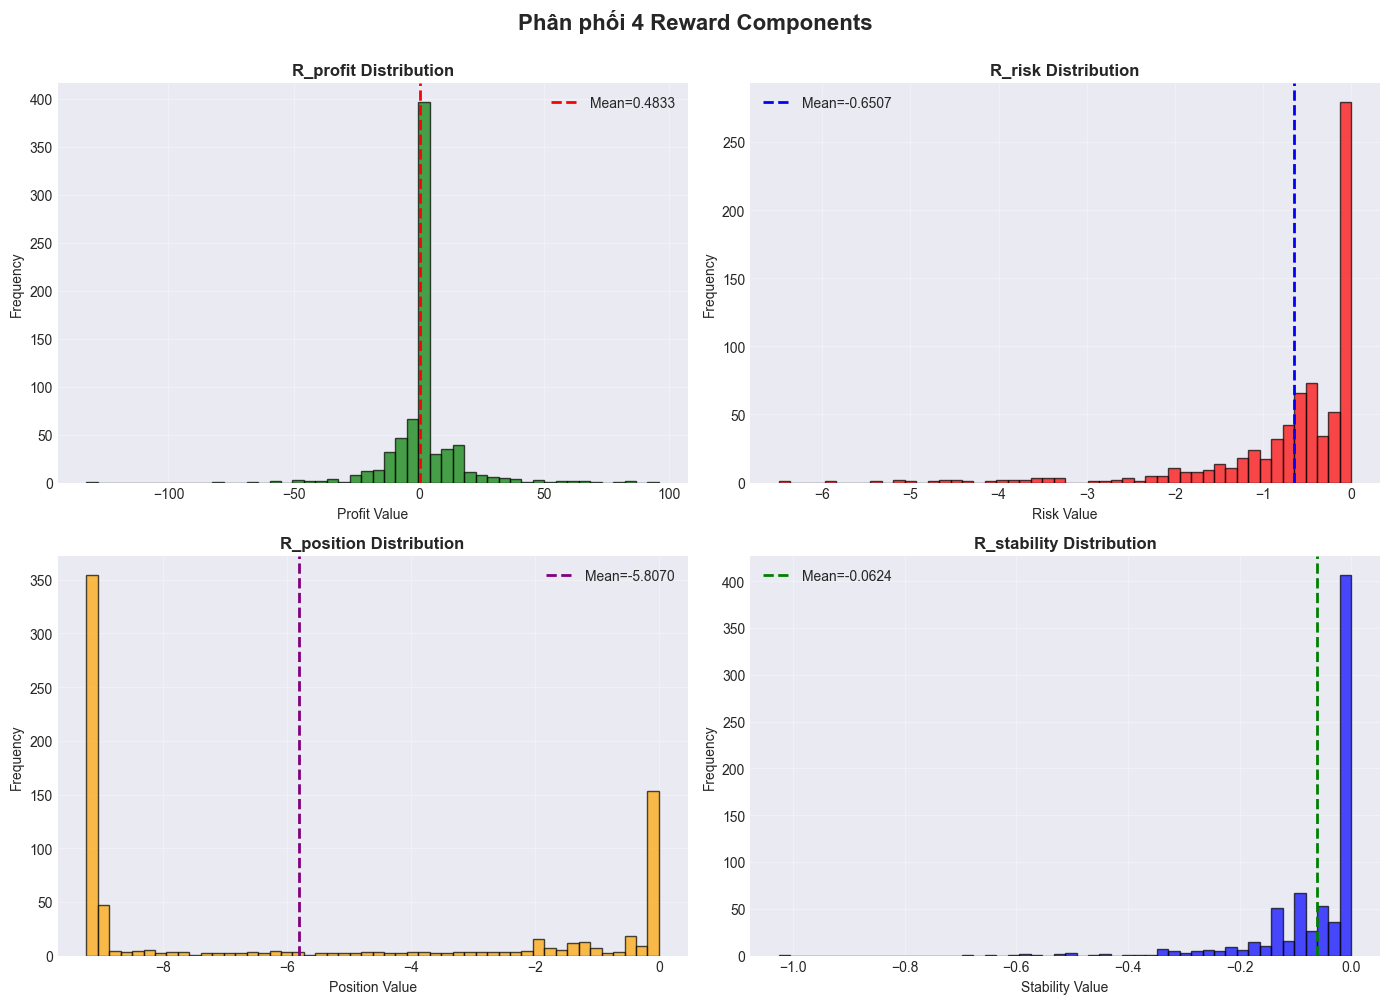

In [41]:
# Histogram phân phối của 4 components
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].hist(R_profit, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,0].set_title('R_profit Distribution', fontweight='bold')
axes[0,0].set_xlabel('Profit Value')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(R_profit.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean={R_profit.mean():.4f}')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].hist(R_risk, bins=50, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_title('R_risk Distribution', fontweight='bold')
axes[0,1].set_xlabel('Risk Value')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(R_risk.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean={R_risk.mean():.4f}')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

axes[1,0].hist(R_position, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,0].set_title('R_position Distribution', fontweight='bold')
axes[1,0].set_xlabel('Position Value')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(R_position.mean(), color='purple', linestyle='--', linewidth=2, label=f'Mean={R_position.mean():.4f}')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

axes[1,1].hist(R_stability, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[1,1].set_title('R_stability Distribution', fontweight='bold')
axes[1,1].set_xlabel('Stability Value')
axes[1,1].set_ylabel('Frequency')
axes[1,1].axvline(R_stability.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean={R_stability.mean():.4f}')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Phân phối 4 Reward Components', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [42]:
# ============================================================================
# PHẦN 1: RDX - ĐỊNH NGHĨA WEIGHTS TỪ DOMAIN KNOWLEDGE
# ============================================================================

# Weights được định nghĩa TRƯỚC dựa trên domain knowledge trading
# KHÔNG dùng gradient hay machine learning để tính weights!

print("="*80)
print("PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION")
print("="*80)

# Domain knowledge weights cho trading strategy
w_rdx = np.array([
    0.40,  # w1 (R_profit):    Profit là mục tiêu chính
    0.30,  # w2 (R_risk):      Risk management quan trọng thứ 2
    0.20,  # w3 (R_position):  Position sizing quan trọng thứ 3
    0.10   # w4 (R_stability): Stability ít quan trọng nhất
])

print("\n✓ RDX Weights (Domain Knowledge):")
print(f"  w1 (R_profit):    {w_rdx[0]:.2f} (40%) - Profit maximization")
print(f"  w2 (R_risk):      {w_rdx[1]:.2f} (30%) - Risk management")
print(f"  w3 (R_position):  {w_rdx[2]:.2f} (20%) - Position sizing")
print(f"  w4 (R_stability): {w_rdx[3]:.2f} (10%) - Portfolio stability")
print(f"  Tổng: {w_rdx.sum():.2f}")

print("\n✓ Giải thích weights:")
print("  • Profit (40%): Trading bot mục tiêu chính là tăng portfolio value")
print("  • Risk (30%):   Risk management để tránh drawdown lớn")
print("  • Position (20%): Quản lý vị thế tránh over-concentration")
print("  • Stability (10%): Giảm biến động nhưng không ưu tiên cao nhất")
print("="*80)

PHẦN 1: RDX - REWARD DECOMPOSITION EXPLANATION

✓ RDX Weights (Domain Knowledge):
  w1 (R_profit):    0.40 (40%) - Profit maximization
  w2 (R_risk):      0.30 (30%) - Risk management
  w3 (R_position):  0.20 (20%) - Position sizing
  w4 (R_stability): 0.10 (10%) - Portfolio stability
  Tổng: 1.00

✓ Giải thích weights:
  • Profit (40%): Trading bot mục tiêu chính là tăng portfolio value
  • Risk (30%):   Risk management để tránh drawdown lớn
  • Position (20%): Quản lý vị thế tránh over-concentration
  • Stability (10%): Giảm biến động nhưng không ưu tiên cao nhất


In [43]:
# Tái tạo reward từ 4 components với RDX weights
R_components = np.column_stack([R_profit, R_risk, R_position, R_stability])
R_reconstructed = R_components @ w_rdx

# Tính metrics để validate RDX
mse = mean_squared_error(R_original, R_reconstructed)
rmse = np.sqrt(mse)
mae = mean_absolute_error(R_original, R_reconstructed)
r2 = r2_score(R_original, R_reconstructed)
correlation = np.corrcoef(R_original, R_reconstructed)[0, 1]

print("✓ RDX Reconstruction Metrics:")
print(f"  MSE:         {mse:.6f}")
print(f"  RMSE:        {rmse:.6f}")
print(f"  MAE:         {mae:.6f}")
print(f"  R² Score:    {r2:.4f} {'✓ Good' if r2 > 0.7 else '✗ Poor'}")
print(f"  Correlation: {correlation:.4f} {'✓ Strong' if abs(correlation) > 0.8 else '~ Moderate' if abs(correlation) > 0.5 else '✗ Weak'}")

# Phân tích reward theo action type
print("\n✓ Reward Analysis by Action Type:")
for action_type, condition in [('BUY', np.array(actions) > 0), 
                                ('SELL', np.array(actions) < 0), 
                                ('HOLD', np.array(actions) == 0)]:
    if np.any(condition):
        avg_original = R_original[condition].mean()
        avg_reconstructed = R_reconstructed[condition].mean()
        error = abs(avg_original - avg_reconstructed)
        count = condition.sum()
        print(f"  {action_type:4s}: R_orig={avg_original:7.4f}, R_recon={avg_reconstructed:7.4f}, err={error:.4f}, n={count}")

# Phân tích đóng góp từng component
print("\n✓ Average Contribution by Component:")
contrib_profit_avg = (w_rdx[0] * R_profit).mean()
contrib_risk_avg = (w_rdx[1] * R_risk).mean()
contrib_position_avg = (w_rdx[2] * R_position).mean()
contrib_stability_avg = (w_rdx[3] * R_stability).mean()

print(f"  Profit contribution:    {contrib_profit_avg:+.4f} ({contrib_profit_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Risk contribution:      {contrib_risk_avg:+.4f} ({contrib_risk_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Position contribution:  {contrib_position_avg:+.4f} ({contrib_position_avg/R_reconstructed.mean()*100:+.1f}%)")
print(f"  Stability contribution: {contrib_stability_avg:+.4f} ({contrib_stability_avg/R_reconstructed.mean()*100:+.1f}%)")

✓ RDX Reconstruction Metrics:
  MSE:         92.997373
  RMSE:        9.643515
  MAE:         4.909293
  R² Score:    0.6210 ✗ Poor
  Correlation: 0.9876 ✓ Strong

✓ Reward Analysis by Action Type:
  BUY : R_orig= 0.6791, R_recon=-1.5253, err=2.2044, n=433
  SELL: R_orig= 0.2331, R_recon=-0.7402, err=0.9732, n=281
  HOLD: R_orig= 0.0000, R_recon=-0.0564, err=0.0564, n=30

✓ Average Contribution by Component:
  Profit contribution:    +0.1933 (-16.5%)
  Risk contribution:      -0.1952 (+16.7%)
  Position contribution:  -1.1614 (+99.3%)
  Stability contribution: -0.0062 (+0.5%)


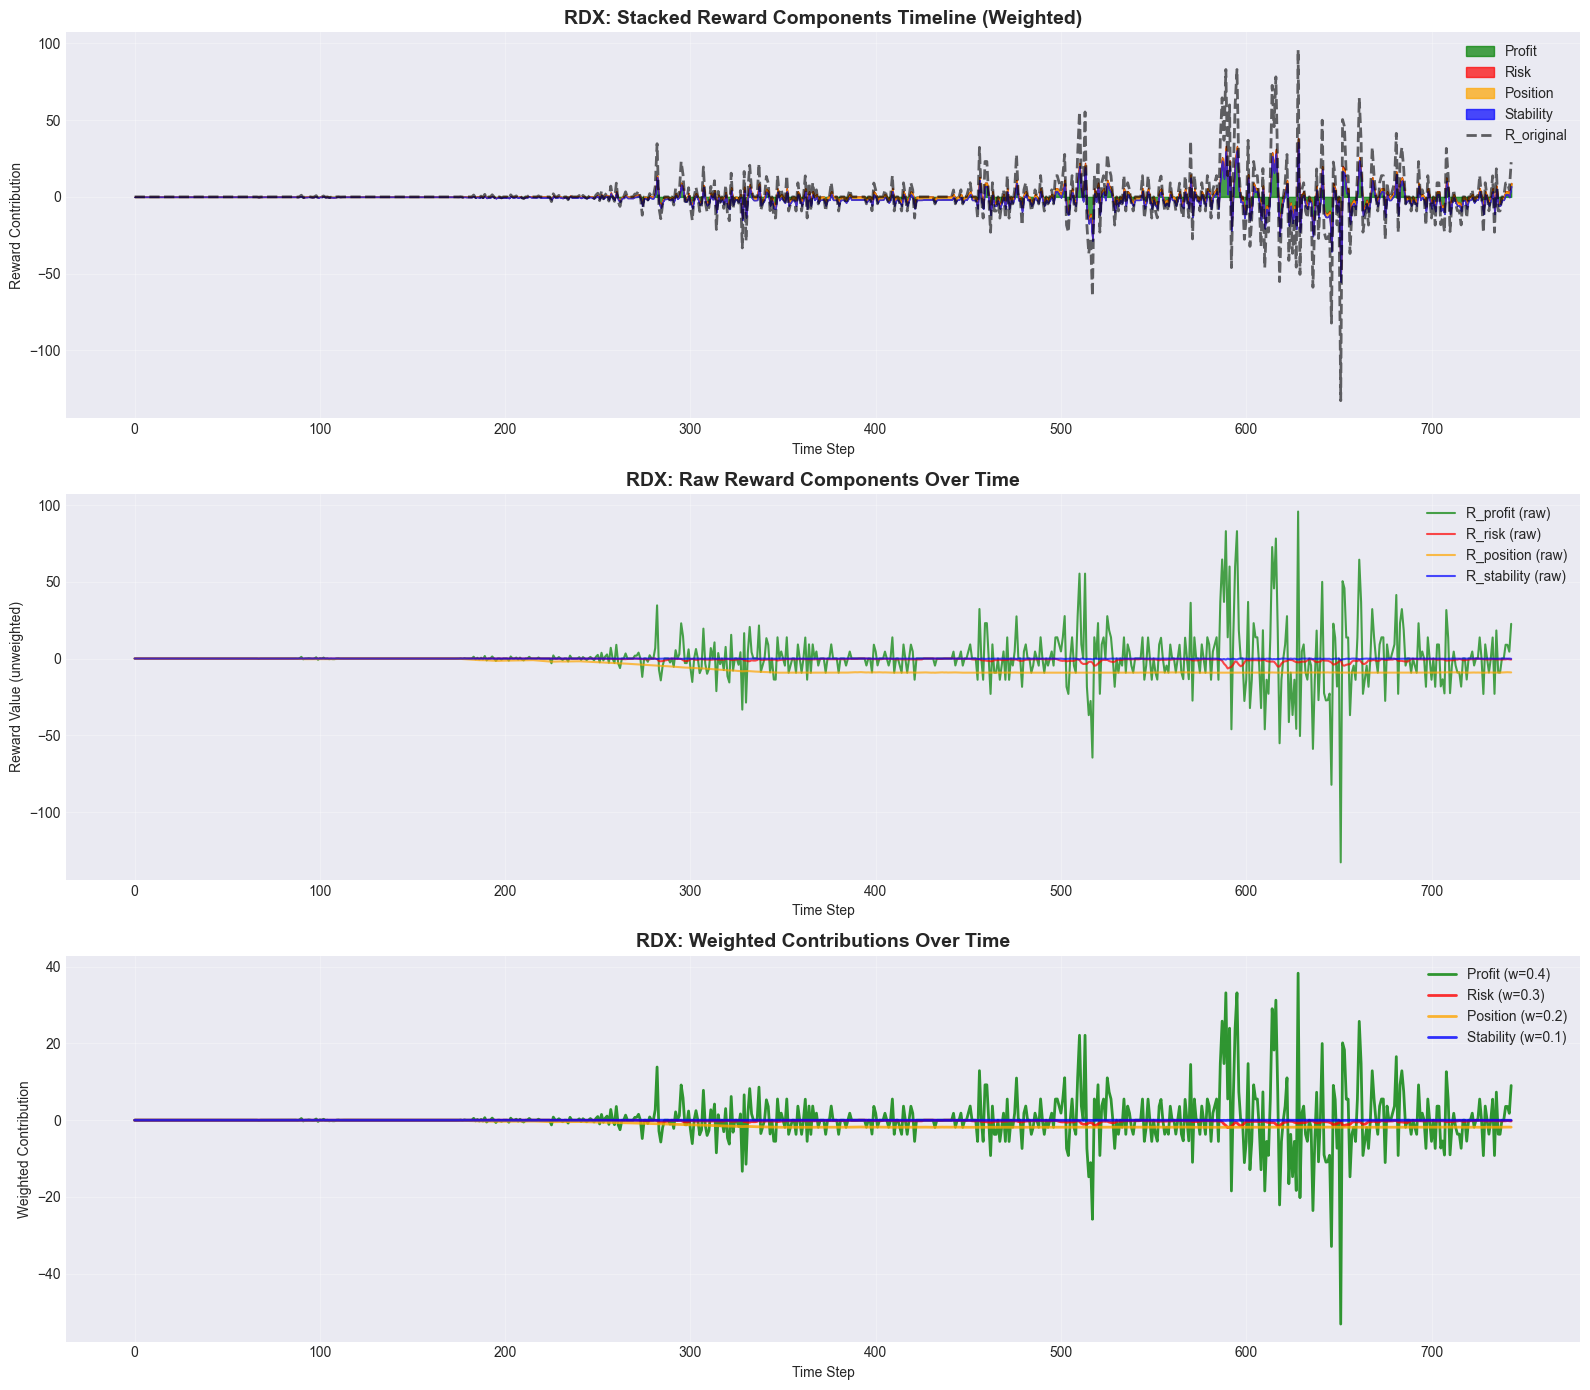

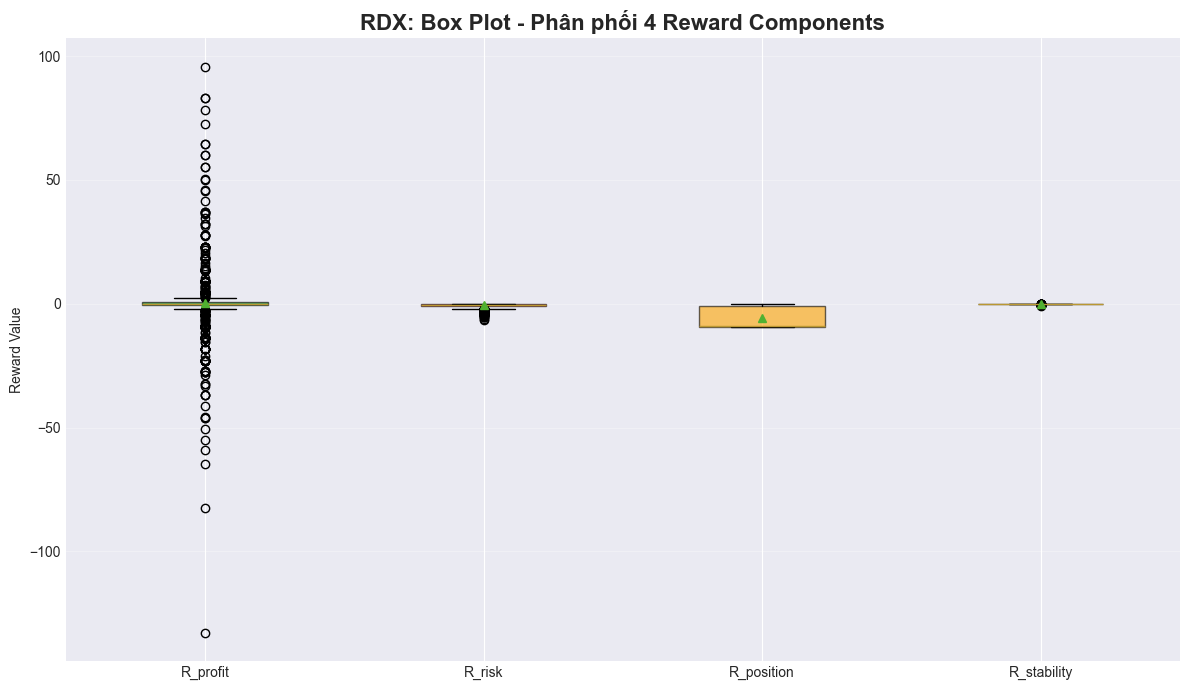

In [44]:
# Weighted contributions của từng component với RDX weights
contrib_profit = w_rdx[0] * R_profit
contrib_risk = w_rdx[1] * R_risk
contrib_position = w_rdx[2] * R_position
contrib_stability = w_rdx[3] * R_stability

# Stacked Area Chart và Timeline
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Subplot 1: Stacked area chart
x = np.arange(len(contrib_profit))
axes[0].fill_between(x, 0, contrib_profit, label='Profit', alpha=0.7, color='green')
axes[0].fill_between(x, contrib_profit, contrib_profit + contrib_risk, 
                     label='Risk', alpha=0.7, color='red')
axes[0].fill_between(x, contrib_profit + contrib_risk, 
                     contrib_profit + contrib_risk + contrib_position,
                     label='Position', alpha=0.7, color='orange')
axes[0].fill_between(x, contrib_profit + contrib_risk + contrib_position,
                     R_reconstructed, label='Stability', alpha=0.7, color='blue')
axes[0].plot(R_original, 'k--', linewidth=2, alpha=0.6, label='R_original')
axes[0].set_title('RDX: Stacked Reward Components Timeline (Weighted)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Reward Contribution')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Individual components over time
axes[1].plot(R_profit, label='R_profit (raw)', alpha=0.7, linewidth=1.5, color='green')
axes[1].plot(R_risk, label='R_risk (raw)', alpha=0.7, linewidth=1.5, color='red')
axes[1].plot(R_position, label='R_position (raw)', alpha=0.7, linewidth=1.5, color='orange')
axes[1].plot(R_stability, label='R_stability (raw)', alpha=0.7, linewidth=1.5, color='blue')
axes[1].set_title('RDX: Raw Reward Components Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Reward Value (unweighted)')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

# Subplot 3: Weighted contributions
axes[2].plot(contrib_profit, label=f'Profit (w={w_rdx[0]:.1f})', linewidth=2, alpha=0.8, color='green')
axes[2].plot(contrib_risk, label=f'Risk (w={w_rdx[1]:.1f})', linewidth=2, alpha=0.8, color='red')
axes[2].plot(contrib_position, label=f'Position (w={w_rdx[2]:.1f})', linewidth=2, alpha=0.8, color='orange')
axes[2].plot(contrib_stability, label=f'Stability (w={w_rdx[3]:.1f})', linewidth=2, alpha=0.8, color='blue')
axes[2].set_title('RDX: Weighted Contributions Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time Step')
axes[2].set_ylabel('Weighted Contribution')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Box plot - Phân phối
fig, ax = plt.subplots(figsize=(12, 7))
data_to_plot = [R_profit, R_risk, R_position, R_stability]
bp = ax.boxplot(data_to_plot, labels=['R_profit', 'R_risk', 'R_position', 'R_stability'],
                patch_artist=True, showmeans=True)

colors = ['green', 'red', 'orange', 'blue']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_title('RDX: Box Plot - Phân phối 4 Reward Components', fontsize=16, fontweight='bold')
ax.set_ylabel('Reward Value')
ax.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 2: MSX - MULTI-STEP EXPLANATION
# ============================================================================

**Mục tiêu:** Phân tích quỹ đạo (trajectory) của agent qua nhiều bước để hiểu:
- **Critical Points**: Các thời điểm quan trọng (reward thay đổi lớn)
- **Phases**: Các giai đoạn BUY/HOLD/SELL
- **Cumulative Analysis**: Sự tích lũy reward theo thời gian

MSX giúp trả lời: "Agent đã hành động như thế nào qua các giai đoạn khác nhau?"

In [45]:
# ============================================================================
# MSX FUNCTIONS - TRAJECTORY ANALYSIS
# ============================================================================

def find_critical_points(rewards, percentile=75):
    """
    Tìm các critical points - timesteps có reward change lớn
    
    Args:
        rewards: array of rewards
        percentile: Ngưỡng phần trăm để xác định "important" (default 75%)
        
    Returns:
        critical_indices: Indices của các critical points
    """
    reward_changes = np.abs(np.diff(rewards))
    threshold = np.percentile(reward_changes, percentile)
    critical_indices = np.where(reward_changes >= threshold)[0]
    return critical_indices

def analyze_trajectory_phase(actions):
    """
    Phân tích các giai đoạn (phases) trong trajectory
    
    Args:
        actions: list of actions [-5 to 5]
        
    Returns:
        phases: list of (start_idx, end_idx, phase_type, avg_action)
    """
    phases = []
    current_phase_type = None
    phase_start = 0
    
    for i, action in enumerate(actions):
        if action > 0:
            phase_type = 'BUY'
        elif action < 0:
            phase_type = 'SELL'
        else:
            phase_type = 'HOLD'
        
        if phase_type != current_phase_type:
            if current_phase_type is not None:
                avg_action = np.mean(actions[phase_start:i])
                phases.append((phase_start, i-1, current_phase_type, avg_action))
            current_phase_type = phase_type
            phase_start = i
    
    # Add last phase
    if current_phase_type is not None:
        avg_action = np.mean(actions[phase_start:])
        phases.append((phase_start, len(actions)-1, current_phase_type, avg_action))
    
    return phases

# ============================================================================
# MSX COMPUTATION
# ============================================================================

print("="*80)
print("PHẦN 2: MSX - MULTI-STEP EXPLANATION")
print("="*80)

# 1. Find critical points
critical_points = find_critical_points(R_original, percentile=75)
print(f"\n✓ Tìm thấy {len(critical_points)} critical points (top 25% reward changes)")
print(f"  Critical timesteps: {critical_points[:10]}..." if len(critical_points) > 10 else f"  Critical timesteps: {critical_points}")

# 2. Analyze phases
phases = analyze_trajectory_phase(actions)
print(f"\n✓ Phân tích trajectory thành {len(phases)} phases:")
for i, (start, end, phase_type, avg_action) in enumerate(phases[:10]):  # Show first 10
    duration = end - start + 1
    print(f"  Phase {i+1}: [{start:4d}-{end:4d}] {phase_type:4s} (duration={duration:3d}, avg_action={avg_action:+.2f})")

if len(phases) > 10:
    print(f"  ... và {len(phases)-10} phases khác")

# 3. Cumulative reward breakdown
cum_rewards = np.cumsum(R_original)
cum_profit = np.cumsum(R_profit)
cum_risk = np.cumsum(w_rdx[1] * R_risk)
cum_position = np.cumsum(w_rdx[2] * R_position)
cum_stability = np.cumsum(w_rdx[3] * R_stability)

print(f"\n✓ Cumulative Analysis:")
print(f"  Final cumulative reward: {cum_rewards[-1]:.2f}")
print(f"  Final cumulative profit: {cum_profit[-1]:.2f}")
print(f"  Final cumulative risk penalty: {cum_risk[-1]:.2f}")
print(f"  Final cumulative position penalty: {cum_position[-1]:.2f}")
print(f"  Final cumulative stability penalty: {cum_stability[-1]:.2f}")

# 4. Phase statistics
phase_stats = {
    'BUY': {'count': 0, 'total_reward': 0, 'avg_reward': 0},
    'SELL': {'count': 0, 'total_reward': 0, 'avg_reward': 0},
    'HOLD': {'count': 0, 'total_reward': 0, 'avg_reward': 0}
}

for start, end, phase_type, _ in phases:
    phase_rewards = R_original[start:end+1]
    phase_stats[phase_type]['count'] += 1
    phase_stats[phase_type]['total_reward'] += phase_rewards.sum()

for phase_type in ['BUY', 'SELL', 'HOLD']:
    if phase_stats[phase_type]['count'] > 0:
        phase_stats[phase_type]['avg_reward'] = phase_stats[phase_type]['total_reward'] / phase_stats[phase_type]['count']

print(f"\n✓ Phase Statistics:")
for phase_type in ['BUY', 'SELL', 'HOLD']:
    stats = phase_stats[phase_type]
    print(f"  {phase_type:4s}: {stats['count']:3d} phases, total_reward={stats['total_reward']:+8.2f}, avg_reward={stats['avg_reward']:+7.2f}")

print("="*80)

PHẦN 2: MSX - MULTI-STEP EXPLANATION

✓ Tìm thấy 188 critical points (top 25% reward changes)
  Critical timesteps: [281 282 294 296 301 306 307 313 314 318]...

✓ Phân tích trajectory thành 138 phases:
  Phase 1: [   0-  13] HOLD (duration= 14, avg_action=+0.00)
  Phase 2: [  14-  66] SELL (duration= 53, avg_action=-2.45)
  Phase 3: [  67-  67] BUY  (duration=  1, avg_action=+3.00)
  Phase 4: [  68-  86] SELL (duration= 19, avg_action=-2.47)
  Phase 5: [  87-  89] BUY  (duration=  3, avg_action=+5.00)
  Phase 6: [  90-  90] SELL (duration=  1, avg_action=-3.00)
  Phase 7: [  91-  92] BUY  (duration=  2, avg_action=+4.00)
  Phase 8: [  93- 106] HOLD (duration= 14, avg_action=+0.00)
  Phase 9: [ 107- 173] SELL (duration= 67, avg_action=-2.28)
  Phase 10: [ 174- 186] BUY  (duration= 13, avg_action=+4.00)
  ... và 128 phases khác

✓ Cumulative Analysis:
  Final cumulative reward: 359.54
  Final cumulative profit: 359.54
  Final cumulative risk penalty: -145.23
  Final cumulative position 

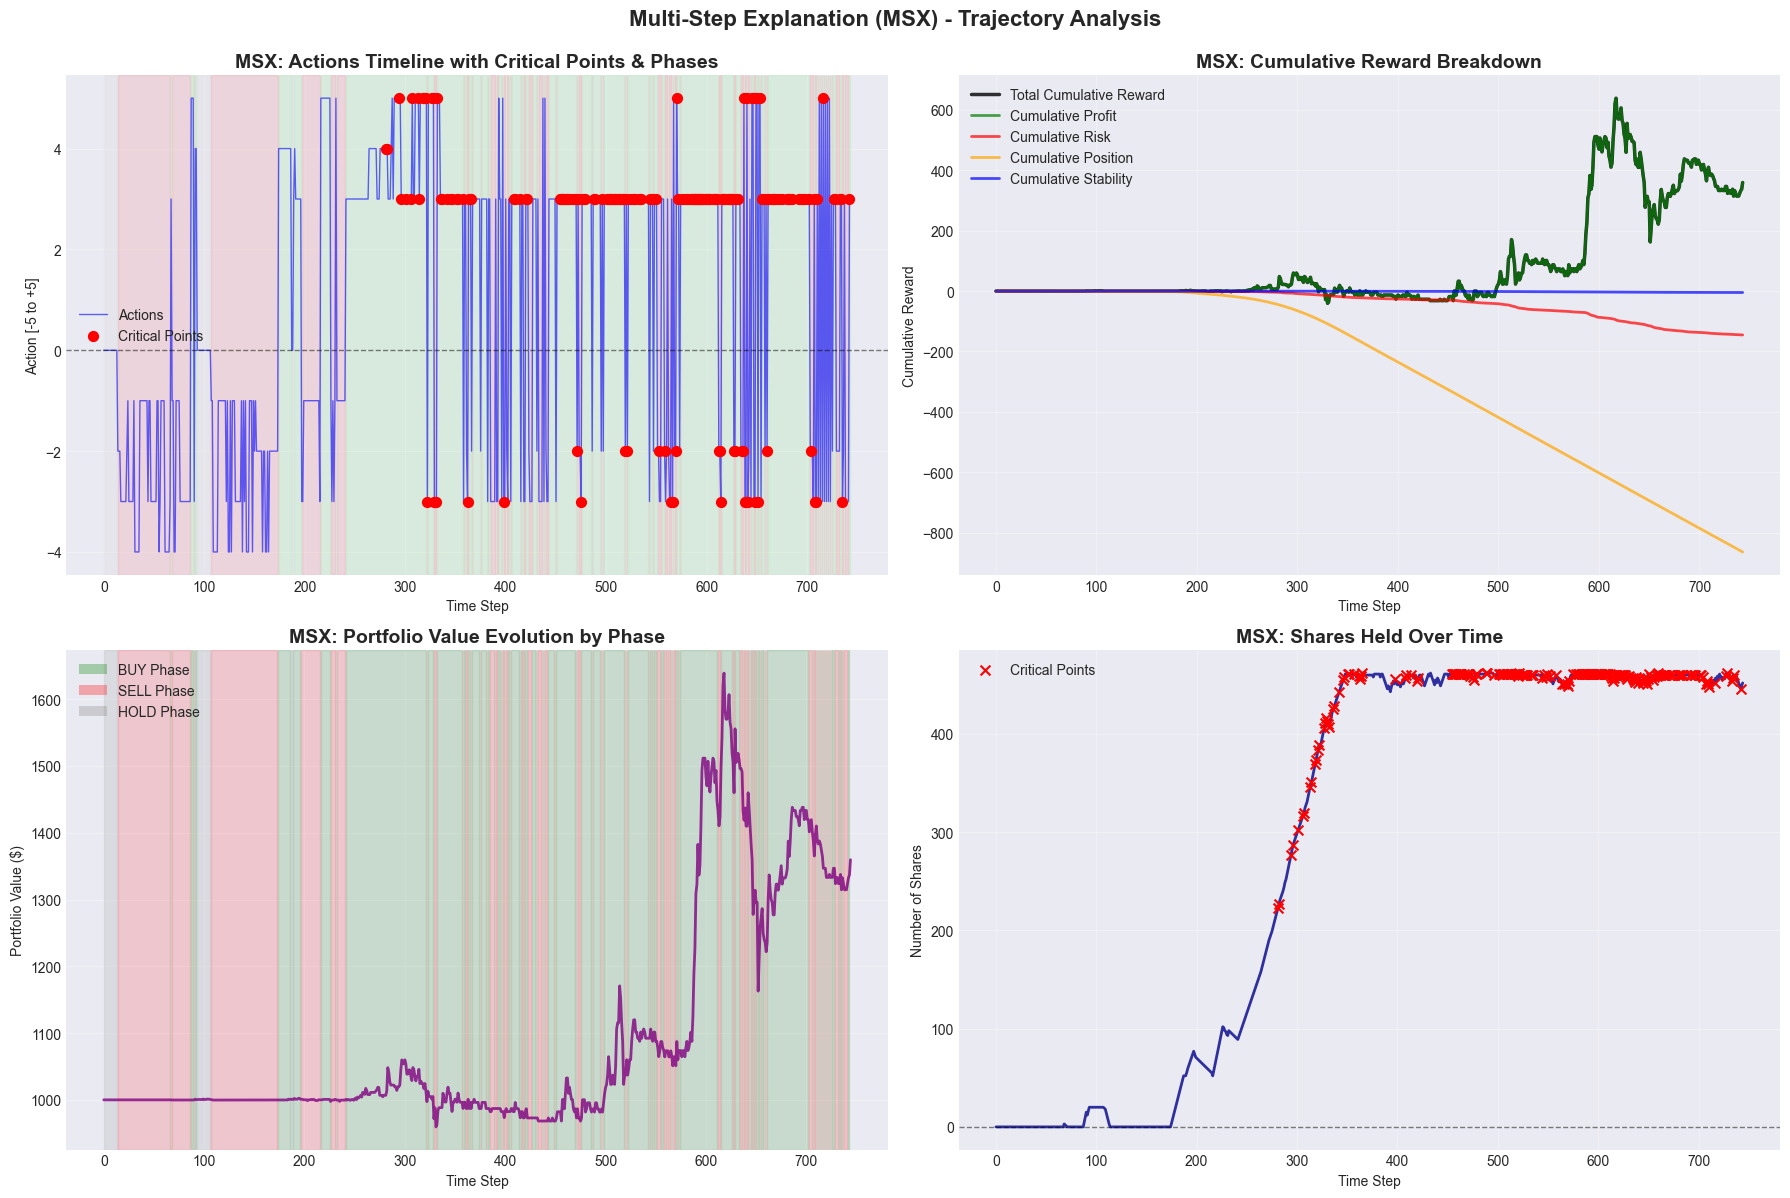

In [46]:
# ============================================================================
# MSX VISUALIZATIONS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Subplot 1: Actions timeline with critical points
axes[0,0].plot(actions, alpha=0.6, linewidth=1, color='blue', label='Actions')
axes[0,0].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
axes[0,0].scatter(critical_points, np.array(actions)[critical_points], 
                  color='red', s=50, marker='o', label='Critical Points', zorder=5)

# Add phase backgrounds
for start, end, phase_type, _ in phases:
    color = 'lightgreen' if phase_type == 'BUY' else 'lightcoral' if phase_type == 'SELL' else 'lightgray'
    axes[0,0].axvspan(start, end, alpha=0.2, color=color)

axes[0,0].set_title('MSX: Actions Timeline with Critical Points & Phases', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Time Step')
axes[0,0].set_ylabel('Action [-5 to +5]')
axes[0,0].legend(loc='best')
axes[0,0].grid(True, alpha=0.3)

# Subplot 2: Cumulative rewards breakdown
axes[0,1].plot(cum_rewards, label='Total Cumulative Reward', linewidth=2.5, color='black', alpha=0.8)
axes[0,1].plot(cum_profit, label='Cumulative Profit', linewidth=2, alpha=0.7, color='green')
axes[0,1].plot(cum_risk, label='Cumulative Risk', linewidth=2, alpha=0.7, color='red')
axes[0,1].plot(cum_position, label='Cumulative Position', linewidth=2, alpha=0.7, color='orange')
axes[0,1].plot(cum_stability, label='Cumulative Stability', linewidth=2, alpha=0.7, color='blue')
axes[0,1].set_title('MSX: Cumulative Reward Breakdown', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Time Step')
axes[0,1].set_ylabel('Cumulative Reward')
axes[0,1].legend(loc='best')
axes[0,1].grid(True, alpha=0.3)

# Subplot 3: Portfolio evolution with phases
portfolio_values = [s[1] + s[2] * s[0] for s in states]  # balance + shares * price
axes[1,0].plot(portfolio_values, linewidth=2, color='purple', alpha=0.8)

# Highlight phases with different colors
for start, end, phase_type, _ in phases:
    color = 'green' if phase_type == 'BUY' else 'red' if phase_type == 'SELL' else 'gray'
    axes[1,0].axvspan(start, end, alpha=0.15, color=color)

axes[1,0].set_title('MSX: Portfolio Value Evolution by Phase', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Time Step')
axes[1,0].set_ylabel('Portfolio Value ($)')
axes[1,0].grid(True, alpha=0.3)

# Add legend for phases
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.3, label='BUY Phase'),
    Patch(facecolor='red', alpha=0.3, label='SELL Phase'),
    Patch(facecolor='gray', alpha=0.3, label='HOLD Phase')
]
axes[1,0].legend(handles=legend_elements, loc='best')

# Subplot 4: Shares held over time
shares_held = [s[2] for s in states]
axes[1,1].plot(shares_held, linewidth=2, color='darkblue', alpha=0.8)
axes[1,1].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Highlight critical points
axes[1,1].scatter(critical_points, np.array(shares_held)[critical_points],
                  color='red', s=50, marker='x', label='Critical Points', zorder=5)

axes[1,1].set_title('MSX: Shares Held Over Time', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Time Step')
axes[1,1].set_ylabel('Number of Shares')
axes[1,1].legend(loc='best')
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Multi-Step Explanation (MSX) - Trajectory Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# PHẦN 3: SHAP - FEATURE ATTRIBUTION ANALYSIS
# ============================================================================

**Mục tiêu:** Sử dụng SHAP (SHapley Additive exPlanations) để:
- Xác định **độ quan trọng** của từng đặc trưng (features) đối với quyết định của agent
- Giải thích **TẠI SAO** agent chọn action cụ thể tại timestep cụ thể
- Trực quan hóa bằng **waterfall plot**, **summary plot**, **bar plot**

SHAP trả lời: "Feature nào ảnh hưởng NHẤT đến quyết định của agent?"

In [47]:
# ============================================================================
# SHAP INITIALIZATION & COMPUTATION
# ============================================================================

print("="*80)
print("PHẦN 3: SHAP - FEATURE ATTRIBUTION ANALYSIS")
print("="*80)

# Prepare data for SHAP
# State features: [close, balance, shares, MACD, RSI, CCI, ADX]
feature_names = ['Close Price', 'Balance', 'Shares', 'MACD', 'RSI', 'CCI', 'ADX']

# Convert states to numpy array
X = np.array(states[:-1])  # Exclude last state (no action after it)
print(f"\n✓ Prepared {X.shape[0]} states with {X.shape[1]} features")
print(f"  Feature names: {feature_names}")

# Define model prediction function for SHAP
def model_predict(state_array):
    """
    SHAP requires a prediction function that returns action probabilities or Q-values
    """
    with torch.no_grad():
        state_tensor = torch.FloatTensor(state_array)
        q_values = qsa(state_tensor)  # Shape: (batch_size, 11)
    return q_values.numpy()

# Test prediction function
print(f"\n✓ Testing model prediction function...")
test_pred = model_predict(X[:5])
print(f"  Input shape: {X[:5].shape}, Output shape: {test_pred.shape}")
print(f"  Q-values range: [{test_pred.min():.4f}, {test_pred.max():.4f}]")

# Initialize SHAP explainer
print(f"\n⏳ Initializing SHAP KernelExplainer...")
print(f"  (This may take a few minutes...)")

# Sample background data (use 100 samples for faster computation)
background_data = shap.sample(X, min(100, len(X)))
print(f"  Background data: {background_data.shape[0]} samples")

# Create SHAP explainer
explainer = shap.KernelExplainer(model_predict, background_data)
print(f"✓ SHAP explainer initialized successfully!")

# Compute SHAP values for a subset of data (to save time)
# We'll analyze 200 samples evenly distributed across the trajectory
n_samples = min(200, len(X))
sample_indices = np.linspace(0, len(X)-1, n_samples, dtype=int)
X_sample = X[sample_indices]

print(f"\n⏳ Computing SHAP values for {n_samples} samples...")
print(f"  (This will take several minutes...)")

# Compute SHAP values
# SHAP values shape: (n_samples, n_features, n_actions)
shap_values = explainer.shap_values(X_sample, nsamples=100)

print(f"✓ SHAP values computed successfully!")

# ============================================================================
# DEBUG: Understand SHAP values structure
# ============================================================================
print(f"  SHAP values structure (DETAILED DEBUG):")
print(f"    - Type: {type(shap_values)}")

if isinstance(shap_values, list):
    print(f"    - It's a LIST with length: {len(shap_values)}")
    print(f"    - First element type: {type(shap_values[0])}")
    print(f"    - First element shape: {shap_values[0].shape}")
    
    # Check if it's really (n_samples, n_features) or something else
    if len(shap_values[0].shape) == 2:
        print(f"    - Interpretation: Each action has shape (n_samples={shap_values[0].shape[0]}, n_features={shap_values[0].shape[1]})")
    else:
        print(f"    - WARNING: Unexpected shape! Check SHAP documentation")
        
elif isinstance(shap_values, np.ndarray):
    print(f"    - It's a NUMPY ARRAY with shape: {shap_values.shape}")
    if len(shap_values.shape) == 3:
        print(f"    - Interpretation: (n_samples={shap_values.shape[0]}, n_features={shap_values.shape[1]}, n_outputs={shap_values.shape[2]})")
    elif len(shap_values.shape) == 2:
        print(f"    - Interpretation: (n_samples={shap_values.shape[0]}, something={shap_values.shape[1]})")
        print(f"    - WARNING: This might be aggregated! Expected 3D array or list of 2D arrays")

# Test extraction for first sample
print(f"\n  Testing extraction for sample 0:")
test_action = actions[sample_indices[0]]
test_action_idx = test_action + 5

if isinstance(shap_values, list):
    print(f"    - shap_values[{test_action_idx}] shape: {shap_values[test_action_idx].shape}")
    print(f"    - shap_values[{test_action_idx}][0] shape: {shap_values[test_action_idx][0].shape}")
    if len(shap_values[test_action_idx].shape) == 2:
        print(f"    - shap_values[{test_action_idx}][0, :] shape: {shap_values[test_action_idx][0, :].shape}")
else:
    print(f"    - Cannot test - shap_values is not a list!")

# ============================================================================
# Extract SHAP values for actual actions
# ============================================================================
print(f"\n  Extracting SHAP values for actual actions...")

actual_actions_sample = [actions[i] for i in sample_indices]
shap_values_actual = np.zeros((n_samples, X.shape[1]))

if isinstance(shap_values, list) and len(shap_values[0].shape) == 2:
    # Case 1: List of (n_samples, n_features) arrays
    for i, sample_idx in enumerate(sample_indices):
        action = actions[sample_idx]
        action_idx = action + 5  # Convert [-5, 5] to [0, 10]
        
        # shap_values[action_idx] has shape (n_samples, n_features)
        # We want row i from that array
        shap_values_actual[i] = shap_values[action_idx][i, :]
        
elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
    # Case 2: Single array with shape (n_samples, n_features, n_outputs)
    for i, sample_idx in enumerate(sample_indices):
        action = actions[sample_idx]
        action_idx = action + 5  # Convert [-5, 5] to [0, 10]
        
        # Extract features for this sample and action
        shap_values_actual[i] = shap_values[i, :, action_idx]
        
else:
    raise ValueError(f"Unexpected SHAP values structure! Type={type(shap_values)}, "
                     f"Shape={shap_values.shape if hasattr(shap_values, 'shape') else 'N/A'}")

print(f"\n✓ Extracted SHAP values for actual actions taken")
print(f"  Shape: {shap_values_actual.shape}")
print(f"  Actions distribution in sample: BUY={sum(1 for a in actual_actions_sample if a > 0)}, "
      f"SELL={sum(1 for a in actual_actions_sample if a < 0)}, "
      f"HOLD={sum(1 for a in actual_actions_sample if a == 0)}")

print("="*80)

PHẦN 3: SHAP - FEATURE ATTRIBUTION ANALYSIS

✓ Prepared 744 states with 7 features
  Feature names: ['Close Price', 'Balance', 'Shares', 'MACD', 'RSI', 'CCI', 'ADX']

✓ Testing model prediction function...
  Input shape: (5, 7), Output shape: (5, 11)
  Q-values range: [-137.2150, 2.6909]

⏳ Initializing SHAP KernelExplainer...
  (This may take a few minutes...)
  Background data: 100 samples
✓ SHAP explainer initialized successfully!

⏳ Computing SHAP values for 200 samples...
  (This will take several minutes...)


  0%|          | 0/200 [00:00<?, ?it/s]

✓ SHAP values computed successfully!
  SHAP values structure (DETAILED DEBUG):
    - Type: <class 'numpy.ndarray'>
    - It's a NUMPY ARRAY with shape: (200, 7, 11)
    - Interpretation: (n_samples=200, n_features=7, n_outputs=11)

  Testing extraction for sample 0:
    - Cannot test - shap_values is not a list!

  Extracting SHAP values for actual actions...

✓ Extracted SHAP values for actual actions taken
  Shape: (200, 7)
  Actions distribution in sample: BUY=121, SELL=71, HOLD=8


In [48]:
# ============================================================================
# SHAP ANALYSIS - FEATURE IMPORTANCE
# ============================================================================

print("="*80)
print("📊 SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# 1. Global Feature Importance (mean absolute SHAP values)
mean_abs_shap = np.abs(shap_values_actual).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_abs_shap,
    'Importance_Pct': mean_abs_shap / mean_abs_shap.sum() * 100
}).sort_values('Importance', ascending=False)

print("\n1️⃣ GLOBAL FEATURE IMPORTANCE (Mean |SHAP|):")
print("-" * 80)
for idx, row in feature_importance.iterrows():
    bar_length = int(row['Importance_Pct'] / 2)
    bar = '█' * bar_length
    print(f"  {row['Feature']:12s} | {row['Importance']:7.4f} | {row['Importance_Pct']:5.1f}% | {bar}")

# 2. Feature importance by action type
print("\n2️⃣ FEATURE IMPORTANCE BY ACTION TYPE:")
print("-" * 80)

# Separate SHAP values by action type
buy_mask = [a > 0 for a in actual_actions_sample]
sell_mask = [a < 0 for a in actual_actions_sample]
hold_mask = [a == 0 for a in actual_actions_sample]

for action_type, mask, mask_name in [
    ('BUY', buy_mask, 'BUY actions'),
    ('SELL', sell_mask, 'SELL actions'),
    ('HOLD', hold_mask, 'HOLD actions')
]:
    if sum(mask) > 0:
        mean_shap = np.abs(shap_values_actual[mask]).mean(axis=0)
        top_feature_idx = np.argmax(mean_shap)
        top_feature = feature_names[top_feature_idx]
        top_importance = mean_shap[top_feature_idx]
        
        print(f"\n  {action_type} ({sum(mask)} samples):")
        print(f"    Top feature: {top_feature} (importance={top_importance:.4f})")
        print(f"    All features:")
        for i, fname in enumerate(feature_names):
            print(f"      {fname:12s}: {mean_shap[i]:7.4f}")

# 3. Top 10 most influential decisions
print("\n3️⃣ TOP 10 MOST INFLUENTIAL DECISIONS (Highest total |SHAP|):")
print("-" * 80)

total_shap_per_sample = np.abs(shap_values_actual).sum(axis=1)
top_10_indices = np.argsort(total_shap_per_sample)[-10:][::-1]

for rank, sample_idx in enumerate(top_10_indices, 1):
    original_idx = sample_indices[sample_idx]
    action = actual_actions_sample[sample_idx]
    total_shap = total_shap_per_sample[sample_idx]
    
    # Find most influential feature for this decision
    most_influential_feat_idx = np.argmax(np.abs(shap_values_actual[sample_idx]))
    most_influential_feat = feature_names[most_influential_feat_idx]
    most_influential_shap = shap_values_actual[sample_idx][most_influential_feat_idx]
    
    action_label = "BUY" if action > 0 else "SELL" if action < 0 else "HOLD"
    
    print(f"  #{rank:2d} | t={original_idx:4d} | {action_label:4s} ({action:+2d}) | "
          f"Total|SHAP|={total_shap:7.4f}")
    print(f"       → Most influential: {most_influential_feat} (SHAP={most_influential_shap:+7.4f})")

# 4. Correlation between features and SHAP values
print("\n4️⃣ FEATURE VALUE vs SHAP VALUE CORRELATION:")
print("-" * 80)

for i, fname in enumerate(feature_names):
    feature_values = X_sample[:, i]
    shap_for_feature = shap_values_actual[:, i]
    
    # Compute correlation
    corr = np.corrcoef(feature_values, shap_for_feature)[0, 1]
    
    print(f"  {fname:12s}: correlation = {corr:+.4f} ", end='')
    if abs(corr) > 0.5:
        print("(STRONG correlation)")
    elif abs(corr) > 0.3:
        print("(MODERATE correlation)")
    else:
        print("(WEAK correlation)")

print("\n" + "="*80)

📊 SHAP FEATURE IMPORTANCE ANALYSIS

1️⃣ GLOBAL FEATURE IMPORTANCE (Mean |SHAP|):
--------------------------------------------------------------------------------
  Shares       |  6.6615 |  38.4% | ███████████████████
  Balance      |  5.3042 |  30.6% | ███████████████
  CCI          |  4.2832 |  24.7% | ████████████
  ADX          |  0.8392 |   4.8% | ██
  RSI          |  0.2075 |   1.2% | 
  Close Price  |  0.0297 |   0.2% | 
  MACD         |  0.0241 |   0.1% | 

2️⃣ FEATURE IMPORTANCE BY ACTION TYPE:
--------------------------------------------------------------------------------

  BUY (121 samples):
    Top feature: Shares (importance=6.6087)
    All features:
      Close Price :  0.0324
      Balance     :  4.7400
      Shares      :  6.6087
      MACD        :  0.0277
      RSI         :  0.2241
      CCI         :  4.0338
      ADX         :  0.9743

  SELL (71 samples):
    Top feature: Shares (importance=7.4546)
    All features:
      Close Price :  0.0221
      Balance     

📊 GENERATING SHAP VISUALIZATIONS...

1️⃣ Creating SHAP Summary Plot (Bee Swarm)...


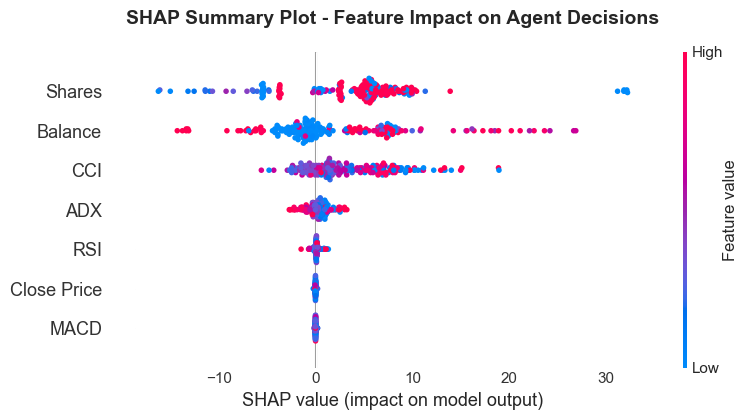

✓ Summary plot created!

2️⃣ Creating SHAP Bar Plot (Global Importance)...


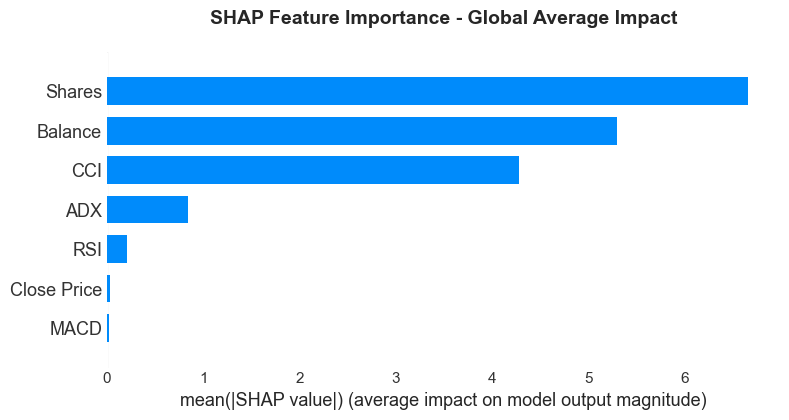

✓ Bar plot created!

3️⃣ Creating SHAP Waterfall Plots - Feature Contributions per Action Type...

   Found 121 BUY, 8 HOLD, 71 SELL decisions
   Showing 3 separate waterfall plots...



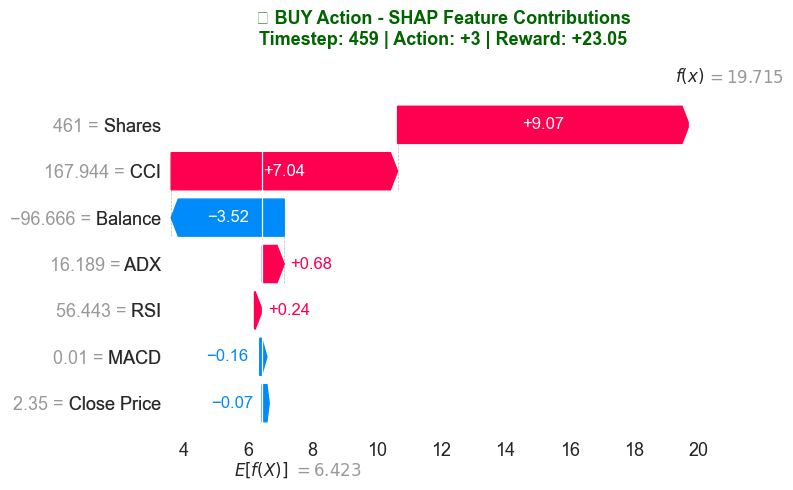

   ✓ BUY waterfall: t=459, action=+3, reward=+23.05


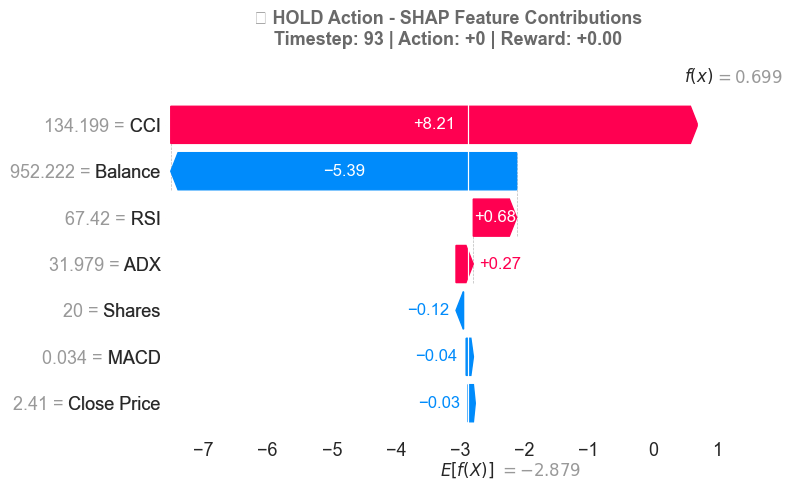

   ✓ HOLD waterfall: t=93, action=+0, reward=+0.00


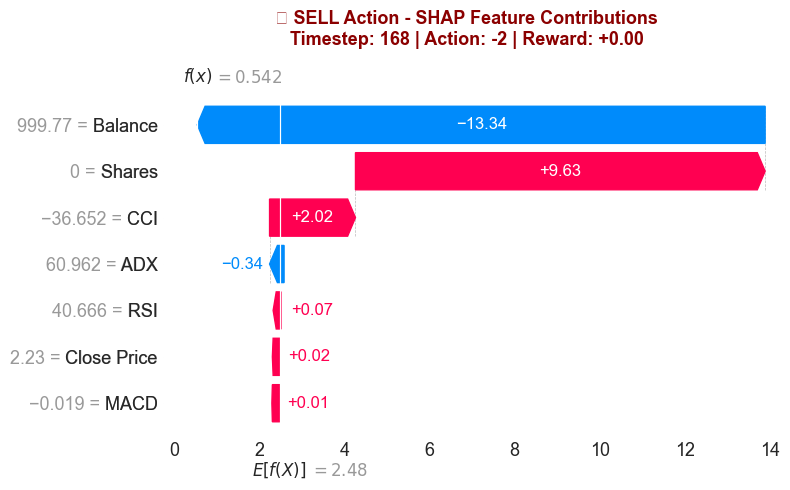

   ✓ SELL waterfall: t=168, action=-2, reward=+0.00

✓ All waterfall plots created - each action shown separately!

4️⃣ Creating SHAP Heatmap - Feature Importance Over Time...


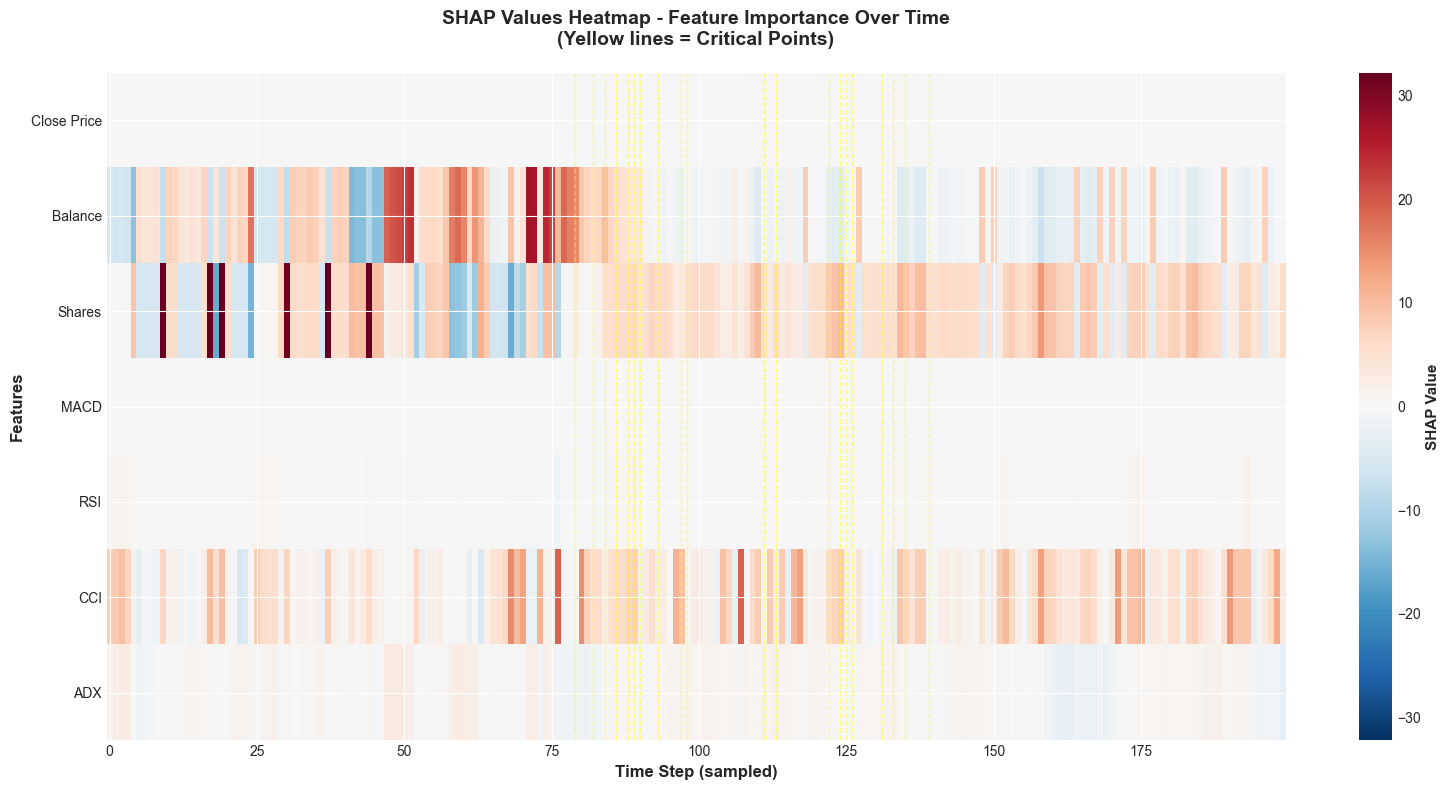

✓ Heatmap created!

5️⃣ Creating Custom Plot - Feature Importance by Trading Phase...


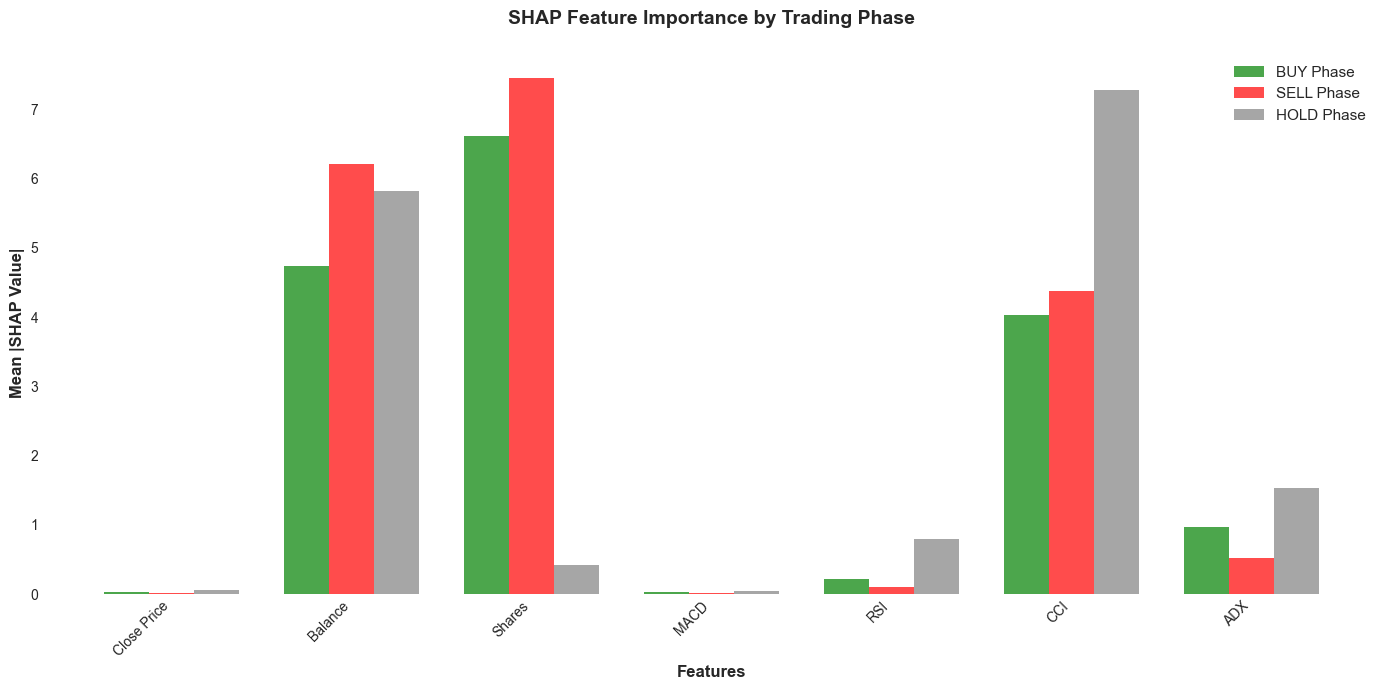

✓ Custom phase plot created!

✓ ALL SHAP VISUALIZATIONS COMPLETED!


In [49]:
# ============================================================================
# SHAP VISUALIZATIONS
# ============================================================================

print("="*80)
print("📊 GENERATING SHAP VISUALIZATIONS...")
print("="*80)

# Setup matplotlib
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================================
# VISUALIZATION 1: SUMMARY PLOT (BEE SWARM)
# ============================================================================
print("\n1️⃣ Creating SHAP Summary Plot (Bee Swarm)...")

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_actual, 
    X_sample, 
    feature_names=feature_names,
    show=False,
    plot_type="dot"
)
plt.title('SHAP Summary Plot - Feature Impact on Agent Decisions', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Summary plot created!")

# ============================================================================
# VISUALIZATION 2: BAR PLOT (GLOBAL FEATURE IMPORTANCE)
# ============================================================================
print("\n2️⃣ Creating SHAP Bar Plot (Global Importance)...")

plt.figure(figsize=(12, 7))
shap.summary_plot(
    shap_values_actual,
    X_sample,
    feature_names=feature_names,
    show=False,
    plot_type="bar"
)
plt.title('SHAP Feature Importance - Global Average Impact', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Bar plot created!")

# ============================================================================
# VISUALIZATION 3: WATERFALL PLOTS - ONE PER ACTION TYPE
# ============================================================================
print("\n3️⃣ Creating SHAP Waterfall Plots - Feature Contributions per Action Type...")

# Tìm 1 quyết định đại diện cho mỗi loại hành động
buy_indices = [i for i, a in enumerate(actual_actions_sample) if a > 0]
sell_indices = [i for i, a in enumerate(actual_actions_sample) if a < 0]
hold_indices = [i for i, a in enumerate(actual_actions_sample) if a == 0]

print(f"\n   Found {len(buy_indices)} BUY, {len(hold_indices)} HOLD, {len(sell_indices)} SELL decisions")
print(f"   Showing 3 separate waterfall plots...\n")

# ============================================================================
# 3.1: BUY ACTION WATERFALL
# ============================================================================
if buy_indices:
    buy_idx = buy_indices[len(buy_indices)//2]  # Quyết định BUY ở giữa
    original_idx = sample_indices[buy_idx]
    action = actual_actions_sample[buy_idx]
    reward = R_original[original_idx]
    
    # Tạo SHAP explanation
    explanation = shap.Explanation(
        values=shap_values_actual[buy_idx],
        base_values=explainer.expected_value[action + 5],
        data=X_sample[buy_idx],
        feature_names=feature_names
    )
    
    # Vẽ waterfall riêng cho BUY
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(explanation, show=False, max_display=10)
    plt.title(
        f'🟢 BUY Action - SHAP Feature Contributions\n' + 
        f'Timestep: {original_idx} | Action: {action:+d} | Reward: {reward:+.2f}',
        fontsize=13, fontweight='bold', color='darkgreen', pad=15
    )
    plt.tight_layout()
    plt.show()
    
    print(f"   ✓ BUY waterfall: t={original_idx}, action={action:+d}, reward={reward:+.2f}")
else:
    print("   ⚠️ No BUY decisions found")

# ============================================================================
# 3.2: HOLD ACTION WATERFALL
# ============================================================================
if hold_indices:
    hold_idx = hold_indices[len(hold_indices)//2]  # Quyết định HOLD ở giữa
    original_idx = sample_indices[hold_idx]
    action = actual_actions_sample[hold_idx]
    reward = R_original[original_idx]
    
    # Tạo SHAP explanation
    explanation = shap.Explanation(
        values=shap_values_actual[hold_idx],
        base_values=explainer.expected_value[action + 5],
        data=X_sample[hold_idx],
        feature_names=feature_names
    )
    
    # Vẽ waterfall riêng cho HOLD
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(explanation, show=False, max_display=10)
    plt.title(
        f'⚪ HOLD Action - SHAP Feature Contributions\n' + 
        f'Timestep: {original_idx} | Action: {action:+d} | Reward: {reward:+.2f}',
        fontsize=13, fontweight='bold', color='dimgray', pad=15
    )
    plt.tight_layout()
    plt.show()
    
    print(f"   ✓ HOLD waterfall: t={original_idx}, action={action:+d}, reward={reward:+.2f}")
else:
    print("   ⚠️ No HOLD decisions found")

# ============================================================================
# 3.3: SELL ACTION WATERFALL
# ============================================================================
if sell_indices:
    sell_idx = sell_indices[len(sell_indices)//2]  # Quyết định SELL ở giữa
    original_idx = sample_indices[sell_idx]
    action = actual_actions_sample[sell_idx]
    reward = R_original[original_idx]
    
    # Tạo SHAP explanation
    explanation = shap.Explanation(
        values=shap_values_actual[sell_idx],
        base_values=explainer.expected_value[action + 5],
        data=X_sample[sell_idx],
        feature_names=feature_names
    )
    
    # Vẽ waterfall riêng cho SELL
    plt.figure(figsize=(10, 6))
    shap.waterfall_plot(explanation, show=False, max_display=10)
    plt.title(
        f'🔴 SELL Action - SHAP Feature Contributions\n' + 
        f'Timestep: {original_idx} | Action: {action:+d} | Reward: {reward:+.2f}',
        fontsize=13, fontweight='bold', color='darkred', pad=15
    )
    plt.tight_layout()
    plt.show()
    
    print(f"   ✓ SELL waterfall: t={original_idx}, action={action:+d}, reward={reward:+.2f}")
else:
    print("   ⚠️ No SELL decisions found")

print("\n✓ All waterfall plots created - each action shown separately!")

# ============================================================================
# VISUALIZATION 4: HEATMAP - SHAP VALUES OVER TIME
# ============================================================================
print("\n4️⃣ Creating SHAP Heatmap - Feature Importance Over Time...")

fig, ax = plt.subplots(figsize=(16, 8))

# Create heatmap of SHAP values over time
im = ax.imshow(shap_values_actual.T, aspect='auto', cmap='RdBu_r', 
               interpolation='nearest', vmin=-np.abs(shap_values_actual).max(),
               vmax=np.abs(shap_values_actual).max())

# Set ticks and labels
ax.set_yticks(np.arange(len(feature_names)))
ax.set_yticklabels(feature_names, fontsize=10)
ax.set_xlabel('Time Step (sampled)', fontsize=12, fontweight='bold')
ax.set_ylabel('Features', fontsize=12, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('SHAP Value', fontsize=11, fontweight='bold')

# Add vertical lines at critical points (if they're in sample)
critical_in_sample = [i for i, idx in enumerate(sample_indices) if idx in critical_points]
for cp_idx in critical_in_sample[:20]:  # Max 20 lines to avoid clutter
    ax.axvline(cp_idx, color='yellow', linestyle='--', alpha=0.5, linewidth=1)

ax.set_title('SHAP Values Heatmap - Feature Importance Over Time\n' + 
             '(Yellow lines = Critical Points)',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✓ Heatmap created!")

# ============================================================================
# VISUALIZATION 5: CUSTOM - FEATURE IMPORTANCE BY PHASE
# ============================================================================
print("\n5️⃣ Creating Custom Plot - Feature Importance by Trading Phase...")

# Aggregate SHAP values by phase type
phase_shap = {
    'BUY': np.abs(shap_values_actual[buy_mask]).mean(axis=0) if sum(buy_mask) > 0 else np.zeros(len(feature_names)),
    'SELL': np.abs(shap_values_actual[sell_mask]).mean(axis=0) if sum(sell_mask) > 0 else np.zeros(len(feature_names)),
    'HOLD': np.abs(shap_values_actual[hold_mask]).mean(axis=0) if sum(hold_mask) > 0 else np.zeros(len(feature_names))
}

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(feature_names))
width = 0.25

bars1 = ax.bar(x - width, phase_shap['BUY'], width, label='BUY Phase', 
               color='green', alpha=0.7)
bars2 = ax.bar(x, phase_shap['SELL'], width, label='SELL Phase', 
               color='red', alpha=0.7)
bars3 = ax.bar(x + width, phase_shap['HOLD'], width, label='HOLD Phase', 
               color='gray', alpha=0.7)

ax.set_xlabel('Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
ax.set_title('SHAP Feature Importance by Trading Phase', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(feature_names, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Custom phase plot created!")

print("\n" + "="*80)
print("✓ ALL SHAP VISUALIZATIONS COMPLETED!")
print("="*80)

📊 RDX - DETAILED COMPONENT REWARD ANALYSIS

1️⃣ Creating Time Period Comparison (Stacked Bar Chart)...


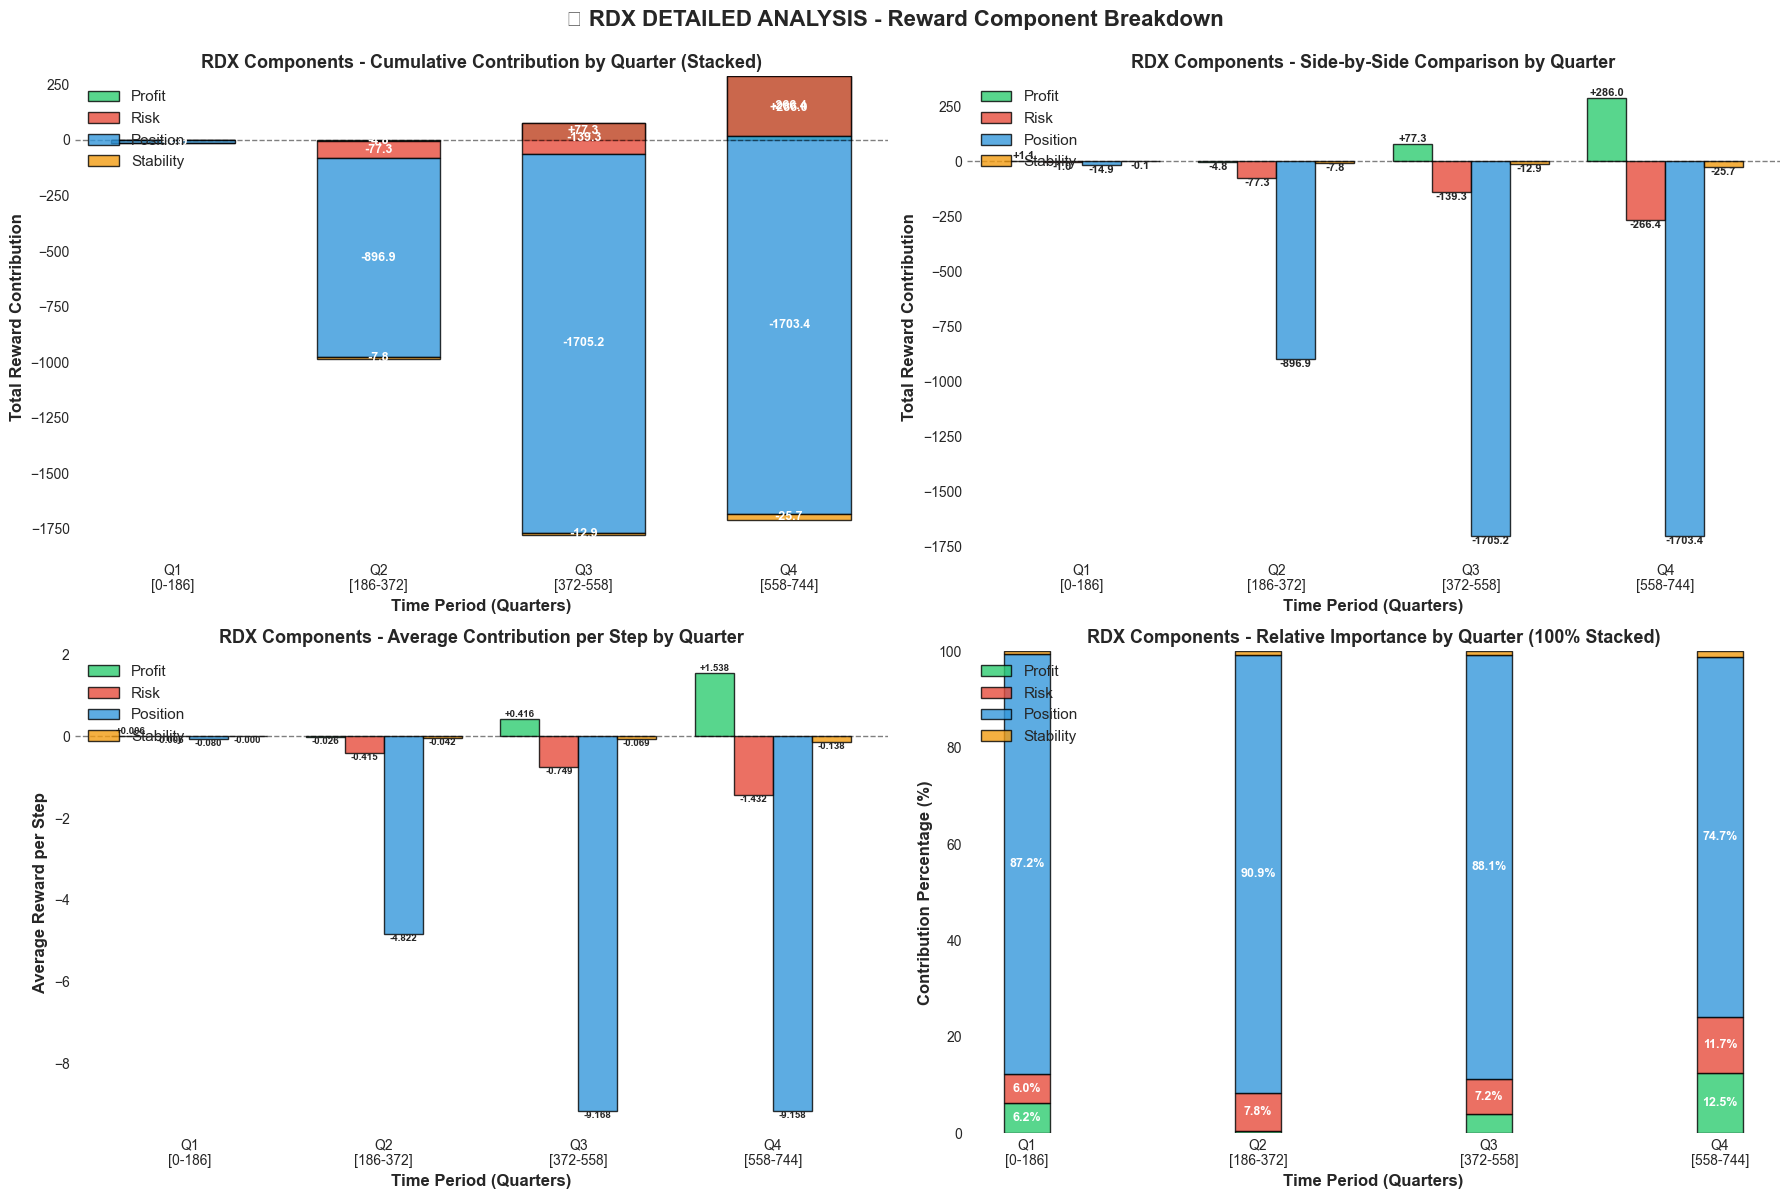


✓ RDX detailed component analysis completed!


In [50]:
# ============================================================================
# ADDITIONAL RDX VISUALIZATION: DETAILED COMPONENT ANALYSIS
# ============================================================================

print("="*80)
print("📊 RDX - DETAILED COMPONENT REWARD ANALYSIS")
print("="*80)

# ============================================================================
# VISUALIZATION 1: Stacked Bar Chart - Reward Components Over Time Periods
# ============================================================================
print("\n1️⃣ Creating Time Period Comparison (Stacked Bar Chart)...")

# Chia dữ liệu thành 4 quarters để so sánh
n_steps = len(R_profit)
quarter_size = n_steps // 4
quarters = []

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

# --- Subplot 1: Stacked Bar Chart by Quarters ---
ax = axes[0]
quarter_labels = []
quarter_data = {
    'Profit': [],
    'Risk': [],
    'Position': [],
    'Stability': []
}

for i in range(4):
    start = i * quarter_size
    end = (i + 1) * quarter_size if i < 3 else n_steps
    quarter_labels.append(f'Q{i+1}\n[{start}-{end}]')
    
    quarter_data['Profit'].append(R_profit[start:end].sum())
    quarter_data['Risk'].append(R_risk[start:end].sum())
    quarter_data['Position'].append(R_position[start:end].sum())
    quarter_data['Stability'].append(R_stability[start:end].sum())

x = np.arange(len(quarter_labels))
width = 0.6

# Create stacked bars
bottom = np.zeros(len(quarter_labels))
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
component_names = ['Profit', 'Risk', 'Position', 'Stability']

for idx, (comp_name, color) in enumerate(zip(component_names, colors)):
    values = quarter_data[comp_name]
    ax.bar(x, values, width, label=comp_name, bottom=bottom, color=color, alpha=0.8, edgecolor='black')
    
    # Add value labels on bars
    for i, v in enumerate(values):
        if abs(v) > 0.01:  # Only show if value is significant
            ax.text(i, bottom[i] + v/2, f'{v:+.1f}', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='white')
    
    bottom += values

ax.set_xlabel('Time Period (Quarters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Reward Contribution', fontsize=12, fontweight='bold')
ax.set_title('RDX Components - Cumulative Contribution by Quarter (Stacked)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(quarter_labels)
ax.legend(loc='upper left', fontsize=11)
ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# --- Subplot 2: Grouped Bar Chart by Quarters ---
ax = axes[1]
width = 0.2
x = np.arange(len(quarter_labels))

bars1 = ax.bar(x - 1.5*width, quarter_data['Profit'], width, label='Profit', 
               color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x - 0.5*width, quarter_data['Risk'], width, label='Risk', 
               color='#e74c3c', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + 0.5*width, quarter_data['Position'], width, label='Position', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars4 = ax.bar(x + 1.5*width, quarter_data['Stability'], width, label='Stability', 
               color='#f39c12', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.01:
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:+.1f}',
                   ha='center', va='bottom' if height > 0 else 'top', 
                   fontsize=8, fontweight='bold')

ax.set_xlabel('Time Period (Quarters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Reward Contribution', fontsize=12, fontweight='bold')
ax.set_title('RDX Components - Side-by-Side Comparison by Quarter', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(quarter_labels)
ax.legend(loc='upper left', fontsize=11)
ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# --- Subplot 3: Average Contribution per Step (Grouped Bar) ---
ax = axes[2]
avg_data = {
    'Profit': [R_profit[i*quarter_size:(i+1)*quarter_size if i<3 else n_steps].mean() for i in range(4)],
    'Risk': [R_risk[i*quarter_size:(i+1)*quarter_size if i<3 else n_steps].mean() for i in range(4)],
    'Position': [R_position[i*quarter_size:(i+1)*quarter_size if i<3 else n_steps].mean() for i in range(4)],
    'Stability': [R_stability[i*quarter_size:(i+1)*quarter_size if i<3 else n_steps].mean() for i in range(4)]
}

x = np.arange(len(quarter_labels))
bars1 = ax.bar(x - 1.5*width, avg_data['Profit'], width, label='Profit', 
               color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x - 0.5*width, avg_data['Risk'], width, label='Risk', 
               color='#e74c3c', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + 0.5*width, avg_data['Position'], width, label='Position', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars4 = ax.bar(x + 1.5*width, avg_data['Stability'], width, label='Stability', 
               color='#f39c12', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if abs(height) > 0.0001:
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:+.3f}',
                   ha='center', va='bottom' if height > 0 else 'top', 
                   fontsize=7, fontweight='bold')

ax.set_xlabel('Time Period (Quarters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Reward per Step', fontsize=12, fontweight='bold')
ax.set_title('RDX Components - Average Contribution per Step by Quarter', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(quarter_labels)
ax.legend(loc='upper left', fontsize=11)
ax.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

# --- Subplot 4: Contribution Percentage (100% Stacked Bar) ---
ax = axes[3]

# Calculate percentage contribution
quarter_totals = []
quarter_pct = {comp: [] for comp in component_names}

for i in range(4):
    total = sum(abs(quarter_data[comp][i]) for comp in component_names)
    quarter_totals.append(total)
    
    for comp in component_names:
        if total > 0:
            pct = abs(quarter_data[comp][i]) / total * 100
            quarter_pct[comp].append(pct)
        else:
            quarter_pct[comp].append(0)

x = np.arange(len(quarter_labels))
bottom = np.zeros(len(quarter_labels))

for idx, (comp_name, color) in enumerate(zip(component_names, colors)):
    values = quarter_pct[comp_name]
    ax.bar(x, values, width, label=comp_name, bottom=bottom, color=color, alpha=0.8, edgecolor='black')
    
    # Add percentage labels
    for i, v in enumerate(values):
        if v > 5:  # Only show if > 5%
            ax.text(i, bottom[i] + v/2, f'{v:.1f}%', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='white')
    
    bottom += values

ax.set_xlabel('Time Period (Quarters)', fontsize=12, fontweight='bold')
ax.set_ylabel('Contribution Percentage (%)', fontsize=12, fontweight='bold')
ax.set_title('RDX Components - Relative Importance by Quarter (100% Stacked)', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(quarter_labels)
ax.legend(loc='upper left', fontsize=11)
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

plt.suptitle('📊 RDX DETAILED ANALYSIS - Reward Component Breakdown', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n✓ RDX detailed component analysis completed!")
print("="*80)



In [51]:
# Print summary statistics
print("\n📊 SUMMARY STATISTICS BY QUARTER:")
print("-"*80)
for i in range(4):
    start = i * quarter_size
    end = (i + 1) * quarter_size if i < 3 else n_steps
    print(f"\nQUARTER {i+1} (Steps {start}-{end}):")
    print(f"  Profit:    {quarter_data['Profit'][i]:+8.2f} (avg: {avg_data['Profit'][i]:+7.4f}/step)")
    print(f"  Risk:      {quarter_data['Risk'][i]:+8.2f} (avg: {avg_data['Risk'][i]:+7.4f}/step)")
    print(f"  Position:  {quarter_data['Position'][i]:+8.2f} (avg: {avg_data['Position'][i]:+7.4f}/step)")
    print(f"  Stability: {quarter_data['Stability'][i]:+8.2f} (avg: {avg_data['Stability'][i]:+7.4f}/step)")
    print(f"  Total:     {sum(quarter_data[c][i] for c in component_names):+8.2f}")
    
    # Find dominant component
    dominant = max(component_names, key=lambda c: abs(quarter_data[c][i]))
    print(f"  Dominant:  {dominant} ({quarter_pct[dominant][i]:.1f}%)")

print("\n" + "="*80)


📊 SUMMARY STATISTICS BY QUARTER:
--------------------------------------------------------------------------------

QUARTER 1 (Steps 0-186):
  Profit:       +1.06 (avg: +0.0057/step)
  Risk:         -1.03 (avg: -0.0055/step)
  Position:    -14.90 (avg: -0.0801/step)
  Stability:    -0.09 (avg: -0.0005/step)
  Total:       -14.96
  Dominant:  Position (87.2%)

QUARTER 2 (Steps 186-372):
  Profit:       -4.82 (avg: -0.0259/step)
  Risk:        -77.28 (avg: -0.4155/step)
  Position:   -896.88 (avg: -4.8219/step)
  Stability:    -7.77 (avg: -0.0418/step)
  Total:      -986.76
  Dominant:  Position (90.9%)

QUARTER 3 (Steps 372-558):
  Profit:      +77.33 (avg: +0.4157/step)
  Risk:       -139.35 (avg: -0.7492/step)
  Position:  -1705.22 (avg: -9.1678/step)
  Stability:   -12.91 (avg: -0.0694/step)
  Total:     -1780.15
  Dominant:  Position (88.1%)

QUARTER 4 (Steps 558-744):
  Profit:     +285.98 (avg: +1.5375/step)
  Risk:       -266.44 (avg: -1.4325/step)
  Position:  -1703.40 (avg: -9.

# ============================================================================
# TỔNG KẾT - XAI-RL FRAMEWORK HOÀN CHỈNH
# ============================================================================

## 🎯 Tổng hợp kết quả từ 3 phương pháp:

### 1️⃣ **RDX (Reward Decomposition Explanation)**
- ✓ Phân tách reward thành 4 components: Profit, Risk, Position, Stability
- ✓ Weights từ domain knowledge: [0.4, 0.3, 0.2, 0.1]
- ✓ Validation metrics: R², correlation, RMSE
- 💡 **Insight:** Hiểu được agent ưu tiên yếu tố nào (profit vs risk)

### 2️⃣ **MSX (Multi-Step Explanation)**  
- ✓ Phân tích trajectory qua critical points và phases
- ✓ Cumulative reward breakdown theo thời gian
- ✓ Phase statistics: BUY/SELL/HOLD performance
- 💡 **Insight:** Hiểu được chiến lược dài hạn của agent (chờ đợi vs hành động ngay)

### 3️⃣ **SHAP (Feature Attribution)**
- ✓ Global feature importance ranking
- ✓ Feature importance by action type (BUY/SELL/HOLD)
- ✓ Individual decision explanations (waterfall plots)
- ✓ Temporal analysis (heatmap over time)
- 💡 **Insight:** Hiểu được feature nào quan trọng nhất cho từng quyết định

---

## 📊 Cách sử dụng framework này:

1. **RDX**: Để hiểu agent ĐÁNH GIÁ reward như thế nào
2. **MSX**: Để hiểu agent HÀNH ĐỘNG theo chiến lược nào
3. **SHAP**: Để hiểu agent DỰA VÀO feature nào để quyết định

---

**🚀 XAI-RL Framework đã hoàn thiện!**

💾 SAVING KEY SUMMARY CHARTS
📁 Folder: ..\results\xai_analysis

1️⃣ Creating Performance Overview Chart...


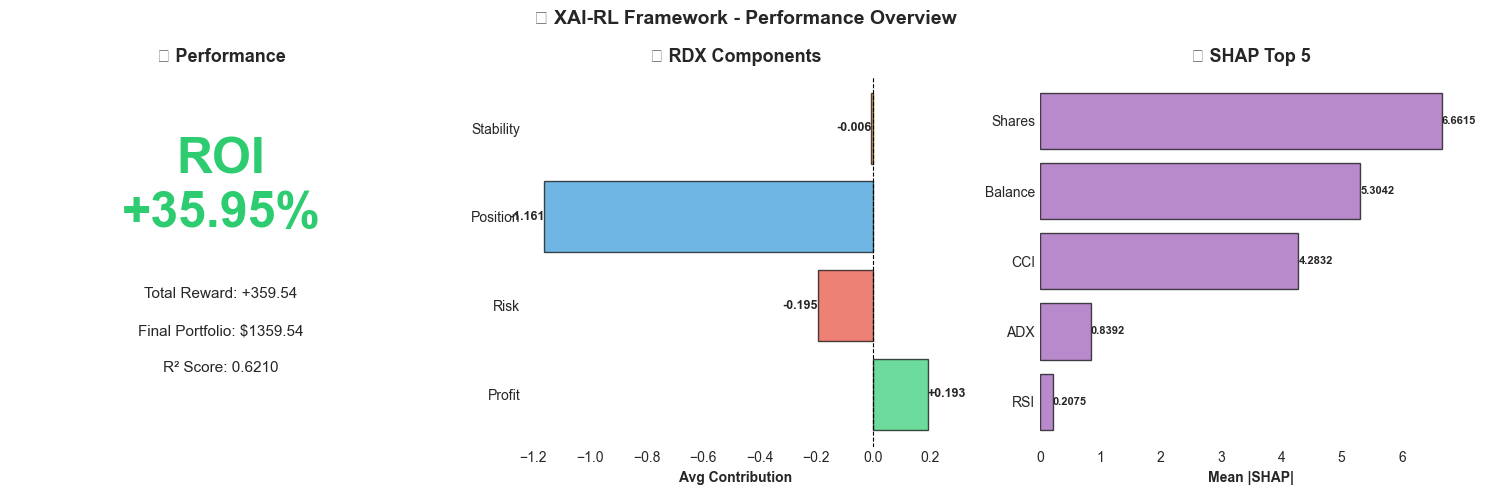

   ✓ Saved: ..\results\xai_analysis\01_performance_20251126_184734.png

2️⃣ Creating Timeline Comparison Chart...


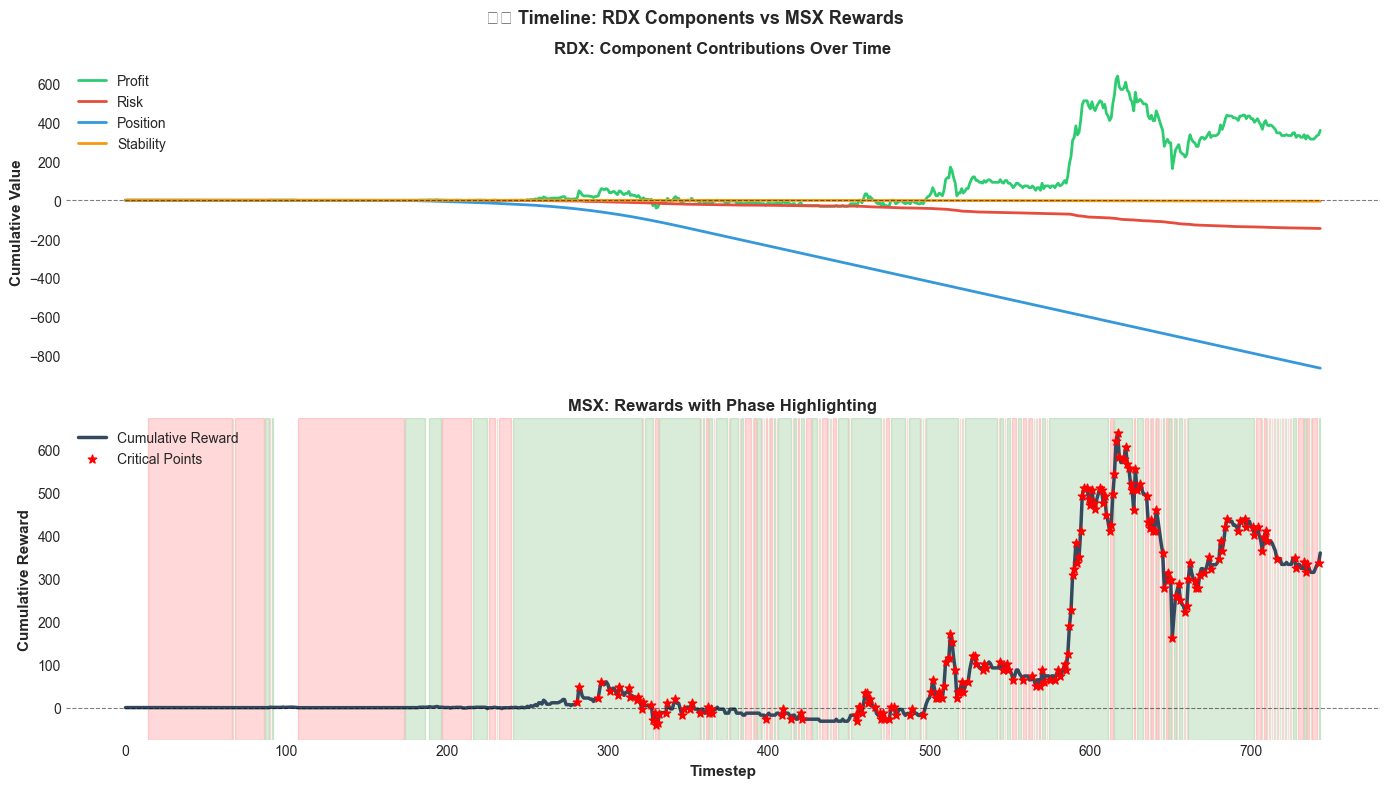

   ✓ Saved: ..\results\xai_analysis\02_timeline_20251126_184734.png

3️⃣ Creating Strategy Analysis Chart...


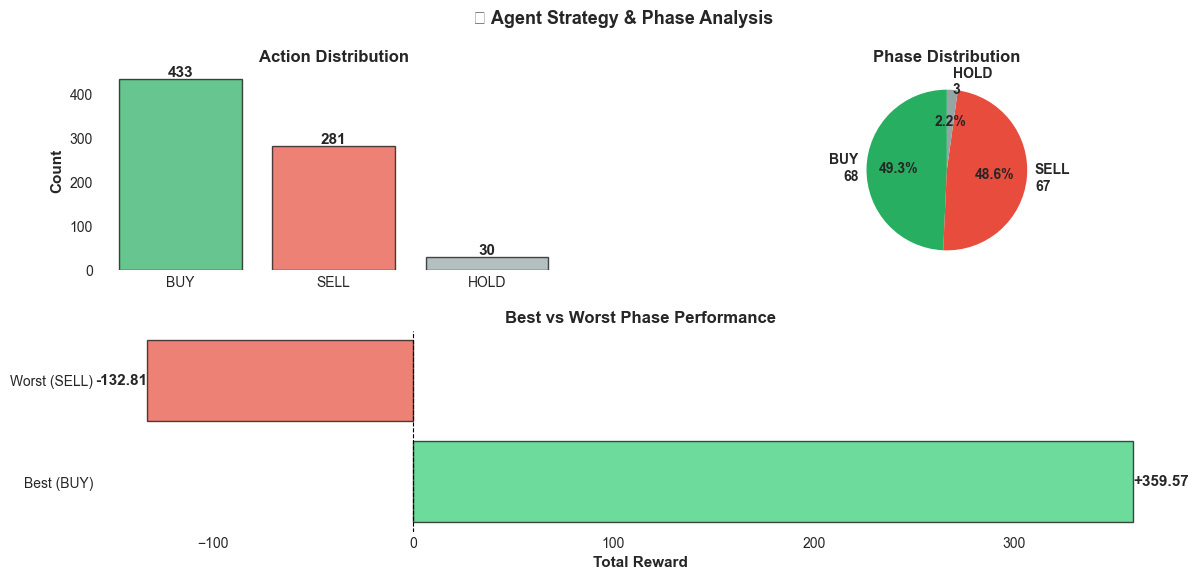

   ✓ Saved: ..\results\xai_analysis\03_strategy_20251126_184734.png

🎉 XAI-RL FRAMEWORK ANALYSIS COMPLETED!

📊 KEY FINDINGS:
  • ROI: +35.95%
  • Strategy Type: CONSERVATIVE (risk-aware)
  • Action Tendency: BULLISH (buy > sell)
  • Dominant Component: Position
  • Top SHAP Feature: Shares
  • Critical Decisions: 188 points

📁 Charts saved to: ..\results\xai_analysis/
  ✓ 01_performance_20251126_184734.png
  ✓ 02_timeline_20251126_184734.png
  ✓ 03_strategy_20251126_184734.png



In [52]:
# ============================================================================
# FINAL SUMMARY - SAVE KEY CHARTS TO RESULTS FOLDER
# ============================================================================

import os
from datetime import datetime

# Tạo folder results nếu chưa có
results_dir = os.path.join('..', 'results', 'xai_analysis')
os.makedirs(results_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("="*80)
print(f"💾 SAVING KEY SUMMARY CHARTS")
print(f"📁 Folder: {results_dir}")
print("="*80)


# ============================================================================
# CHART 1: Performance Overview
# ============================================================================
print("\n1️⃣ Creating Performance Overview Chart...")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# --- Subplot 1: ROI & Key Metrics ---
ax = axes[0]
ax.axis('off')
roi_color = '#2ecc71' if roi > 0 else '#e74c3c'
ax.text(0.5, 0.7, f"ROI\n{roi:+.2f}%", ha='center', va='center', 
        fontsize=36, fontweight='bold', color=roi_color)
ax.text(0.5, 0.40, f"Total Reward: {R_original.sum():+.2f}", ha='center', fontsize=11)
ax.text(0.5, 0.30, f"Final Portfolio: ${final_portfolio:.2f}", ha='center', fontsize=11)
ax.text(0.5, 0.20, f"R² Score: {r2:.4f}", ha='center', fontsize=11)
ax.set_title('💰 Performance', fontsize=13, fontweight='bold', pad=10)

# --- Subplot 2: RDX Components ---
ax = axes[1]
rdx_names = ['Profit', 'Risk', 'Position', 'Stability']
rdx_values = [contrib_profit_avg, contrib_risk_avg, contrib_position_avg, contrib_stability_avg]
rdx_colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
bars = ax.barh(rdx_names, rdx_values, color=rdx_colors, alpha=0.7, edgecolor='black')
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_xlabel('Avg Contribution', fontsize=10, fontweight='bold')
ax.set_title('🔍 RDX Components', fontsize=13, fontweight='bold', pad=10)
ax.grid(axis='x', alpha=0.3)
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:+.3f}', 
            ha='left' if width > 0 else 'right', va='center', fontsize=9, fontweight='bold')

# --- Subplot 3: SHAP Top Features ---
ax = axes[2]
top_5 = feature_importance.head(5)
bars = ax.barh(top_5['Feature'], top_5['Importance'], 
               color='#9b59b6', alpha=0.7, edgecolor='black')
ax.set_xlabel('Mean |SHAP|', fontsize=10, fontweight='bold')
ax.set_title('⭐ SHAP Top 5', fontsize=13, fontweight='bold', pad=10)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}', 
            ha='left', va='center', fontsize=8, fontweight='bold')

plt.suptitle('📊 XAI-RL Framework - Performance Overview', fontsize=14, fontweight='bold')
plt.tight_layout()
chart1_path = os.path.join(results_dir, f'01_performance_{timestamp}.png')
plt.savefig(chart1_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"   ✓ Saved: {chart1_path}")

# ============================================================================
# CHART 2: Timeline Comparison (Compact)
# ============================================================================
print("\n2️⃣ Creating Timeline Comparison Chart...")

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# --- Timeline 1: RDX Cumulative Components ---
ax = axes[0]
ax.plot(cum_profit, label='Profit', color='#2ecc71', linewidth=2)
ax.plot(cum_risk, label='Risk', color='#e74c3c', linewidth=2)
ax.plot(cum_position, label='Position', color='#3498db', linewidth=2)
ax.plot(cum_stability, label='Stability', color='#f39c12', linewidth=2)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
ax.set_ylabel('Cumulative Value', fontsize=11, fontweight='bold')
ax.set_title('RDX: Component Contributions Over Time', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

# --- Timeline 2: MSX Cumulative Rewards with Phases ---
ax = axes[1]
ax.plot(cum_rewards, color='#34495e', linewidth=2.5, label='Cumulative Reward')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)

# Highlight phases (phases is list of tuples: (start, end, phase_type, avg_action))
for start, end, phase_type, _ in phases:
    if phase_type == 'BUY':
        ax.axvspan(start, end, alpha=0.15, color='green')
    elif phase_type == 'SELL':
        ax.axvspan(start, end, alpha=0.15, color='red')

# Mark critical points
ax.scatter(critical_points, cum_rewards[critical_points], color='red', s=40, 
           marker='*', zorder=5, label='Critical Points')

ax.set_xlabel('Timestep', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Reward', fontsize=11, fontweight='bold')
ax.set_title('MSX: Rewards with Phase Highlighting', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.suptitle('⏱️ Timeline: RDX Components vs MSX Rewards', fontsize=13, fontweight='bold')
plt.tight_layout()
chart2_path = os.path.join(results_dir, f'02_timeline_{timestamp}.png')
plt.savefig(chart2_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"   ✓ Saved: {chart2_path}")

# ============================================================================
# CHART 3: Strategy & Phase Analysis
# ============================================================================
print("\n3️⃣ Creating Strategy Analysis Chart...")

# Find best and worst phases (phases is list of tuples)
phase_details_for_sort = []
for start, end, phase_type, avg_action in phases:
    phase_reward = R_original[start:end+1].sum()
    phase_details_for_sort.append({
        'start': start,
        'end': end,
        'type': phase_type,
        'avg_action': avg_action,
        'total_reward': phase_reward
    })

best_phase = max(phase_details_for_sort, key=lambda x: x['total_reward'])
worst_phase = min(phase_details_for_sort, key=lambda x: x['total_reward'])

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# --- Subplot 1: Action Distribution ---
ax = fig.add_subplot(gs[0, 0])
action_counts = [total_buy, total_sell, total_hold]
action_labels = ['BUY', 'SELL', 'HOLD']
action_colors = ['#27ae60', '#e74c3c', '#95a5a6']
bars = ax.bar(action_labels, action_counts, color=action_colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_title('Action Distribution', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Subplot 2: Phase Distribution ---
ax = fig.add_subplot(gs[0, 1])
phase_counts = [phase_stats['BUY']['count'], phase_stats['SELL']['count'], phase_stats['HOLD']['count']]
phase_labels = [f"BUY\n{phase_stats['BUY']['count']}", 
                f"SELL\n{phase_stats['SELL']['count']}", 
                f"HOLD\n{phase_stats['HOLD']['count']}"]
wedges, texts, autotexts = ax.pie(phase_counts, labels=phase_labels, colors=action_colors, 
                                    autopct='%1.1f%%', startangle=90, 
                                    textprops={'fontsize': 10, 'fontweight': 'bold'})
ax.set_title('Phase Distribution', fontsize=12, fontweight='bold')

# --- Subplot 3: Best vs Worst Phases ---
ax = fig.add_subplot(gs[1, :])
phase_names = [f"Best ({best_phase['type']})", f"Worst ({worst_phase['type']})"]
phase_rewards = [best_phase['total_reward'], worst_phase['total_reward']]
phase_colors_bar = ['#2ecc71', '#e74c3c']
bars = ax.barh(phase_names, phase_rewards, color=phase_colors_bar, alpha=0.7, edgecolor='black')
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_xlabel('Total Reward', fontsize=11, fontweight='bold')
ax.set_title('Best vs Worst Phase Performance', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:+.2f}',
            ha='left' if width > 0 else 'right', va='center', fontsize=11, fontweight='bold')

plt.suptitle('🎯 Agent Strategy & Phase Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
chart3_path = os.path.join(results_dir, f'03_strategy_{timestamp}.png')
plt.savefig(chart3_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"   ✓ Saved: {chart3_path}")

# ============================================================================
# SUMMARY REPORT
# ============================================================================
print("\n" + "="*80)
print("🎉 XAI-RL FRAMEWORK ANALYSIS COMPLETED!")
print("="*80)

# Determine strategy characteristics
if abs(contrib_profit_avg) > abs(contrib_risk_avg):
    strategy_type = "AGGRESSIVE (profit-focused)"
else:
    strategy_type = "CONSERVATIVE (risk-aware)"

if total_buy > total_sell:
    action_tendency = "BULLISH (buy > sell)"
elif total_sell > total_buy:
    action_tendency = "BEARISH (sell > buy)"
else:
    action_tendency = "NEUTRAL (balanced)"

dominant_component = max([('Profit', abs(contrib_profit_avg)), 
                          ('Risk', abs(contrib_risk_avg)), 
                          ('Position', abs(contrib_position_avg)), 
                          ('Stability', abs(contrib_stability_avg))], 
                         key=lambda x: x[1])[0]

print(f"\n📊 KEY FINDINGS:")
print(f"  • ROI: {roi:+.2f}%")
print(f"  • Strategy Type: {strategy_type}")
print(f"  • Action Tendency: {action_tendency}")
print(f"  • Dominant Component: {dominant_component}")
print(f"  • Top SHAP Feature: {feature_importance.iloc[0]['Feature']}")
print(f"  • Critical Decisions: {len(critical_points)} points")

print(f"\n📁 Charts saved to: {results_dir}/")
print(f"  ✓ 01_performance_{timestamp}.png")
print(f"  ✓ 02_timeline_{timestamp}.png")
print(f"  ✓ 03_strategy_{timestamp}.png")

print("\n" + "="*80)